# Artificial Neural Networks and Deep Learning - Homework 1















- Team: Bio.log(y)







- Members: Luca Lepore, Arianna Rigamonti, Michele Sala, Jacopo Libero Tettamanti















---















## VGG16 on pre-processed data

### ⚙️ Import Libraries

In [36]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np
import pandas as pd

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
import keras as tfk
from keras.layers import Input, Dense, Dropout, Lambda
from keras import layers as tfkl
import keras_cv.layers as cv_layers

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")

# Import other libraries
import cv2
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO
from sklearn.utils import resample, shuffle
from sklearn.utils.class_weight import compute_class_weight
from ipywidgets import interact, IntSlider, Dropdown
from tensorflow.keras.utils import to_categorical
import plotly.express as px
import imagehash
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

TensorFlow version: 2.16.1
Keras version: 3.3.3


## ⏳ Load Data

In [37]:
# Load your dataset
train_augmented = np.load('/kaggle/input/datasetfinal/X_train_augmented_3x.npz')
X_train = train_augmented['images']
y_train = train_augmented['labels']

val_augmented = np.load('/kaggle/input/datasetfinal/X_val_augmented_3x.npz')
X_val = val_augmented['images']
y_val = val_augmented['labels']

test = np.load('/kaggle/input/datasetfinal/X_test.npz')
X_test = test['images']
y_test = test['labels']

test_augmented = np.load('/kaggle/input/datasetfinal/X_test_augmented_4x.npz')
X_test_augmented = test_augmented['images']
y_test_augmented = test_augmented['labels']

# Define class labels
labels = {0: "Basophil", 1: "Eosinophil", 2: "Erythroblast", 3: "Immature granulocytes",
          4: "Lymphocyte", 5: "Monocyte", 6: "Neutrophil", 7: "Platelet"}

# Save unique labels
unique_labels = list(labels.values())
print(f'Unique labels: {unique_labels}')

Unique labels: ['Basophil', 'Eosinophil', 'Erythroblast', 'Immature granulocytes', 'Lymphocyte', 'Monocyte', 'Neutrophil', 'Platelet']


In [38]:
# Check the shape of the loaded images
print(f"Loaded X_train images shape: {X_train.shape}")
print(f"Loaded y_train labels shape: {y_train.shape}")
print(f"Min value X_train: {X_train.min()}, Max value X_train: {X_train.max()}\n")

print(f"Loaded X_val images shape: {X_val.shape}")
print(f"Loaded y_val labels shape: {y_val.shape}")
print(f"Min value X_val: {X_val.min()}, Max value X_val: {X_val.max()}\n")

print(f"Loaded X_test images shape: {X_test.shape}")
print(f"Loaded y_test labels shape: {y_test.shape}")
print(f"Min value X_test: {X_test.min()}, Max value X_test: {X_test.max()}\n")

print(f"Loaded X_test_augmented images shape: {X_test_augmented.shape}")
print(f"Loaded y_test_augmented labels shape: {y_test_augmented.shape}")
print(f"Min value X_test_augmented: {X_test_augmented.min()}, Max value X_test_augmented: {X_test_augmented.max()}")

Loaded X_train images shape: (21513, 96, 96, 3)
Loaded y_train labels shape: (21513, 8)
Min value X_train: 0.0, Max value X_train: 255.0

Loaded X_val images shape: (7173, 96, 96, 3)
Loaded y_val labels shape: (7173, 8)
Min value X_val: 0.0, Max value X_val: 255.0

Loaded X_test images shape: (2391, 96, 96, 3)
Loaded y_test labels shape: (2391, 8)
Min value X_test: 0, Max value X_test: 255

Loaded X_test_augmented images shape: (9564, 96, 96, 3)
Loaded y_test_augmented labels shape: (9564, 8)
Min value X_test_augmented: 0.0, Max value X_test_augmented: 255.0


## 🔎 Inspect Data

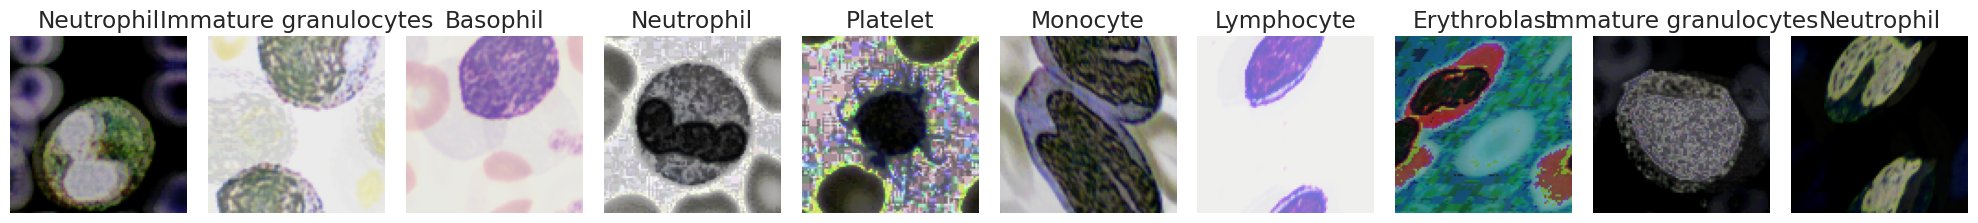

In [39]:
# Number of images to display
num_img = 10

# Set a random seed for reproducibility
random.seed(seed)

# Select random indices
random_indices = random.sample(range(len(X_train)), num_img)

# Create subplots
fig, axes = plt.subplots(1, num_img, figsize=(20, 5))

for i, idx in enumerate(random_indices):
    ax = axes[i]
    
    # Get the image and cast it to uint8
    image = X_train[idx]
    image_uint8 = (image).astype(np.uint8)
    
    # Handle color and grayscale images
    if image_uint8.shape[-1] == 1:
        image_uint8 = np.squeeze(image_uint8, axis=-1)
        ax.imshow(image_uint8, cmap='gray', vmin=0, vmax=255)
    else:
        ax.imshow(image_uint8)

    # Set the title based on the label
    label_index = np.argmax(y_train[idx])
    label = labels[label_index]
    
    ax.set_title(f'{label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

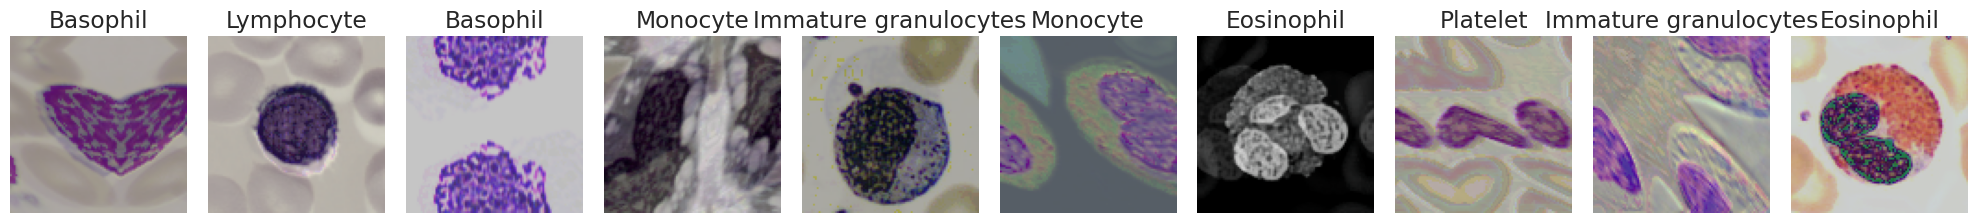

In [40]:
# Number of images to display
num_img = 10

# Set a random seed for reproducibility
random.seed(seed)

# Select random indices
random_indices = random.sample(range(len(X_val)), num_img)

# Create subplots
fig, axes = plt.subplots(1, num_img, figsize=(20, 5))

for i, idx in enumerate(random_indices):
    ax = axes[i]

    # Get the image and cast it to uint8
    image = X_val[idx]
    image_uint8 = (image).astype(np.uint8)

    # Handle color and grayscale images
    if image_uint8.shape[-1] == 1:
        image_uint8 = np.squeeze(image_uint8, axis=-1)
        ax.imshow(image_uint8, cmap='gray', vmin=0, vmax=255)
    else:
        ax.imshow(image_uint8)

    # Set the title based on the label
    label_index = np.argmax(y_val[idx])
    label = labels[label_index]
    ax.set_title(f'{label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

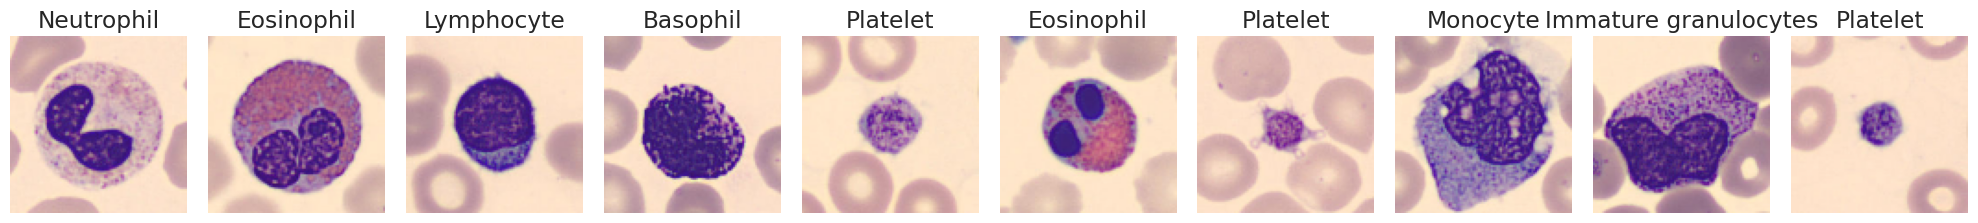

In [41]:
# Number of images to display
num_img = 10

# Set a random seed for reproducibility
random.seed(seed)

# Select random indices
random_indices = random.sample(range(len(X_test)), num_img)

# Create subplots
fig, axes = plt.subplots(1, num_img, figsize=(20, 5))

for i, idx in enumerate(random_indices):
    ax = axes[i]

    # Get the image and cast it to uint8
    image = X_test[idx]
    image_uint8 = (image).astype(np.uint8)

    # Handle color and grayscale images
    if image_uint8.shape[-1] == 1:
        image_uint8 = np.squeeze(image_uint8, axis=-1)
        ax.imshow(image_uint8, cmap='gray', vmin=0, vmax=255)
    else:
        ax.imshow(image_uint8)

    # Set the title based on the label
    label_index = np.argmax(y_test[idx])
    label = labels[label_index]
    ax.set_title(f'{label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

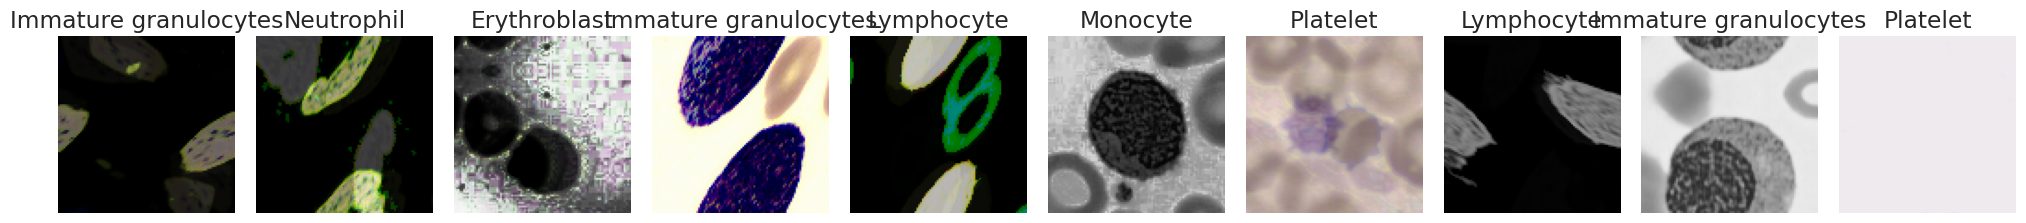

In [42]:
# Number of images to display
num_img = 10

# Set a random seed for reproducibility
random.seed(seed)

# Select random indices
random_indices = random.sample(range(len(X_test_augmented)), num_img)

# Create subplots
fig, axes = plt.subplots(1, num_img, figsize=(20, 5))

for i, idx in enumerate(random_indices):
    ax = axes[i]

    # Get the image and cast it to uint8
    image = X_test_augmented[idx]
    image_uint8 = (image).astype(np.uint8)

    # Handle color and grayscale images
    if image_uint8.shape[-1] == 1:
        image_uint8 = np.squeeze(image_uint8, axis=-1)
        ax.imshow(image_uint8, cmap='gray', vmin=0, vmax=255)
    else:
        ax.imshow(image_uint8)

    # Set the title based on the label
    label_index = np.argmax(y_test_augmented[idx])
    label = labels[label_index]
    ax.set_title(f'{label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

### Class balancing

In [43]:
# Flatten the labels to class indices since they're in one-hot encoding
y_train_flat = np.argmax(y_train, axis=1)

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_flat),
    y=y_train_flat
)

# Convert the class weights to a dictionary
class_weight_dict = dict(enumerate(class_weights))

# Print the calculated class weights
print("Class weights:")
for class_index, weight in class_weight_dict.items():
    print(f"Class {class_index}: Weight {weight:.2f}")

Class weights:
Class 0: Weight 1.75
Class 1: Weight 0.69
Class 2: Weight 1.38
Class 3: Weight 0.74
Class 4: Weight 1.76
Class 5: Weight 1.50
Class 6: Weight 0.64
Class 7: Weight 0.91


## 🧮 Define Network Parameters

In [44]:
# Input shape for the model
input_shape = X_train.shape[1:]

# Output shape for the model
output_shape = y_train.shape[1]

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Input Shape: (96, 96, 3)
Output Shape: 8


In [45]:
# Number of training epochs
epochs = 200

# Batch size for training
batch_size = 64

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)

Epochs: 200
Batch Size: 64


## **VGG16 (Simonyan & Zisserman, 2014)**

<img src="https://neurohive.io/wp-content/uploads/2018/11/vgg16-neural-network.jpg" width="300"/>

---

**Key Features and Achievements**

*   Introduced a deep architecture using only 3x3 convolutional layers.
*   Emphasized the importance of depth in achieving high performance on image classification.
*   Established itself as a cornerstone for deep learning in computer vision.
*   Simplified the architecture compared to earlier designs like AlexNet.

**Key building block:**

*   A stack of convolutional layers with a fixed kernel size (3x3) and small strides (1x1), followed by **MaxPooling** layers for down-sampling.
*   Fully-connected dense layers at the end for feature aggregation and classification.
*   Adopted **ReLU** activation for non-linearity.

**Impact:**

*   Achieved state-of-the-art results on ImageNet in 2014.
*   Became a foundational architecture for transfer learning in deep learning applications.
*   Simplified and improved reproducibility in deep network designs.
*   Influenced deeper architectures like ResNet and Inception by demonstrating the benefits of deeper networks.

**📜 Paper:** ["Very Deep Convolutional Networks for Large-Scale Image Recognition", Simonyan & Zisserman](https://arxiv.org/pdf/1409.1556)

---

<img src="https://neurohive.io/wp-content/uploads/2018/11/Capture-564x570.jpg" width="300"/>

## 🛠️ Transfer Learning















<img src="https://radekosmulski.com/content/images/2021/08/imagenet_banner.jpeg" width="700"/>

In [46]:
# Initialise VGG16 model with pretrained weights, for transfer learning
weights_path = '/kaggle/input/weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

vgg16 = tfk.applications.VGG16(
    input_shape=input_shape,
    include_top=False,
    weights=weights_path,
    pooling='avg'
)

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 96, 96, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 96, 96, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 48, 48, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 48, 48, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

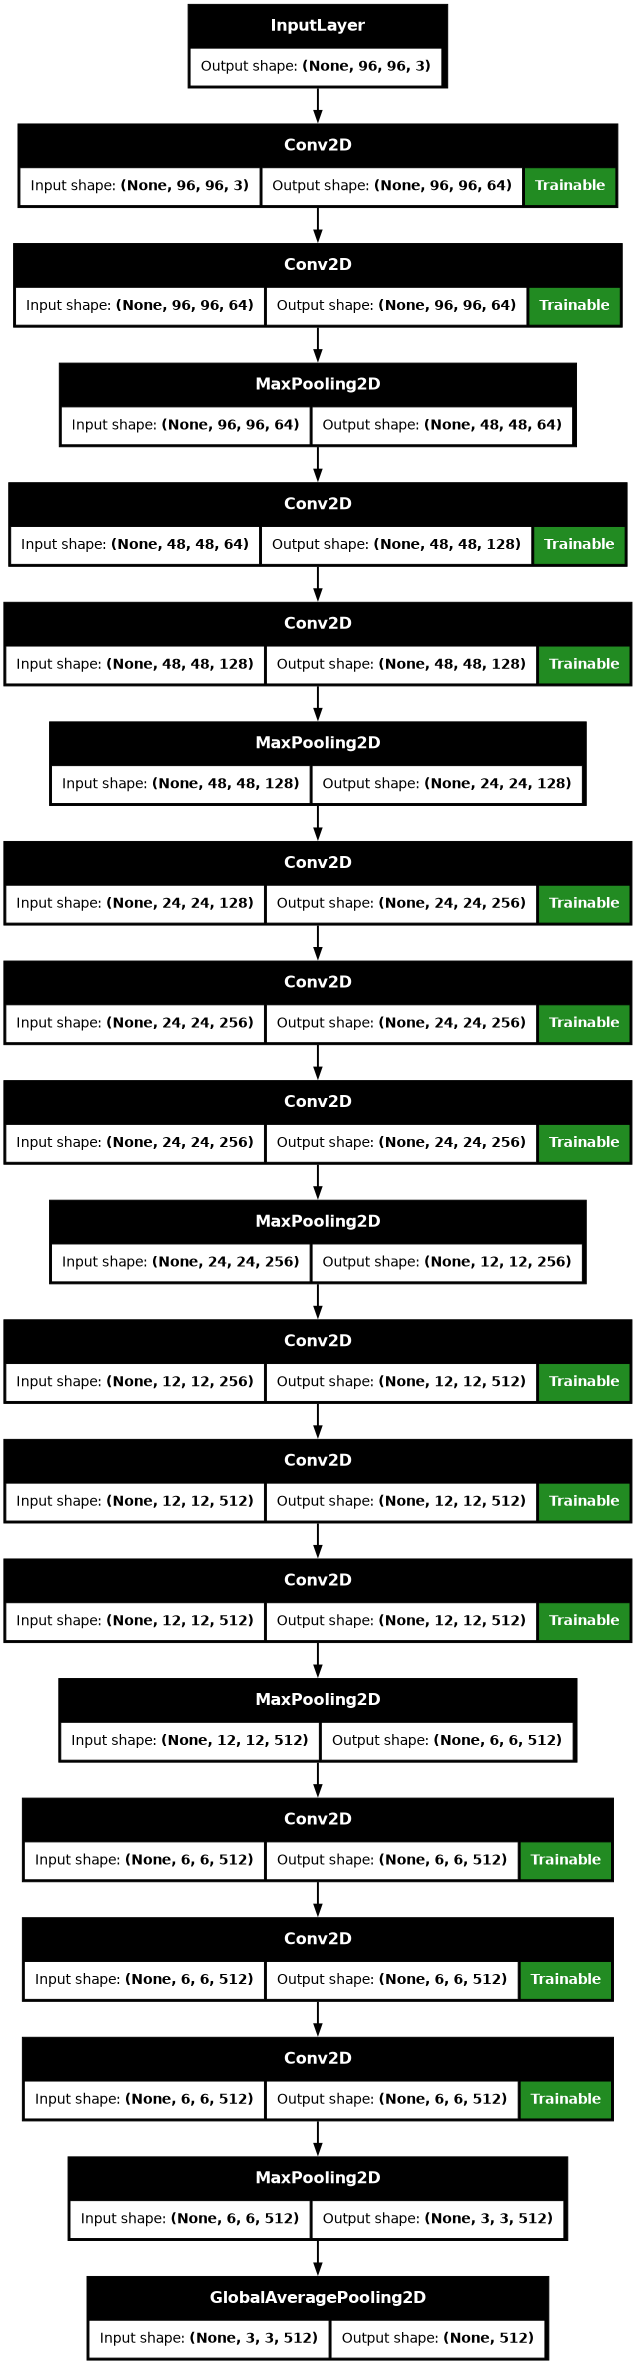

In [47]:
# Display a summary of the model architecture
vgg16.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(vgg16, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

#### Model with 1 dense layer

In [48]:
# Freeze all layers in VGG16 to use it solely as a feature extractor
vgg16.trainable = False

# Define input layer with shape matching the input images
inputs = tfk.Input(shape=input_shape, name='input_layer') 

# Apply input preprocessing for VGG16
preprocessed_inputs = preprocess_input(inputs) # convert the input images from RGB to BGR, then will zero-center each color channel with respect to the ImageNet dataset, without scaling.

# Pass inputs through the VGG16 feature extractor
x = vgg16(preprocessed_inputs)
print("Shape after VGG16:", x.shape)

# Add a Dropout layer for regularisation
x = tfkl.Dropout(0.3, name='dropout1')(x)
print("Shape after Dropout1:", x.shape)

# Add a final Dense layer for classification with softmax activation
outputs = tfkl.Dense(y_train.shape[-1], activation='softmax', name='dense3')(x)
print("Shape after Dense1:", outputs.shape)

# Define the complete model linking input and output
tl_model1 = tfk.Model(inputs=inputs, outputs=outputs, name='model1')

# Compile the model with categorical cross-entropy loss and Adam optimiser
tl_model1.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])  # default learning rate = 0.001

Shape after VGG16: (None, 512)
Shape after Dropout1: (None, 512)
Shape after Dense1: (None, 8)


Model: "model1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_6          │ (None, 96, 96)    │          0 │ input_layer[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_7          │ (None, 96, 96)    │          0 │ input_layer[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_8          │ (None, 96, 96)    │          0 │ input_layer[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_2 (Stack)     │ (None, 96, 96, 3) │          0 │ get_item_6[0][0], │
│                     │                   │            │ get_item_7[0][0], │
│                     │                   │            │ get_item_8[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 96, 96, 3) │          0 │ stack_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 512)       │ 14,714,688 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout1 (Dropout)  │ (None, 512)       │          0 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense3 (Dense)      │ (None, 8)         │      4,104 │ dropout1[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,718,792 (56.15 MB)

 Trainable params: 4,104 (16.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

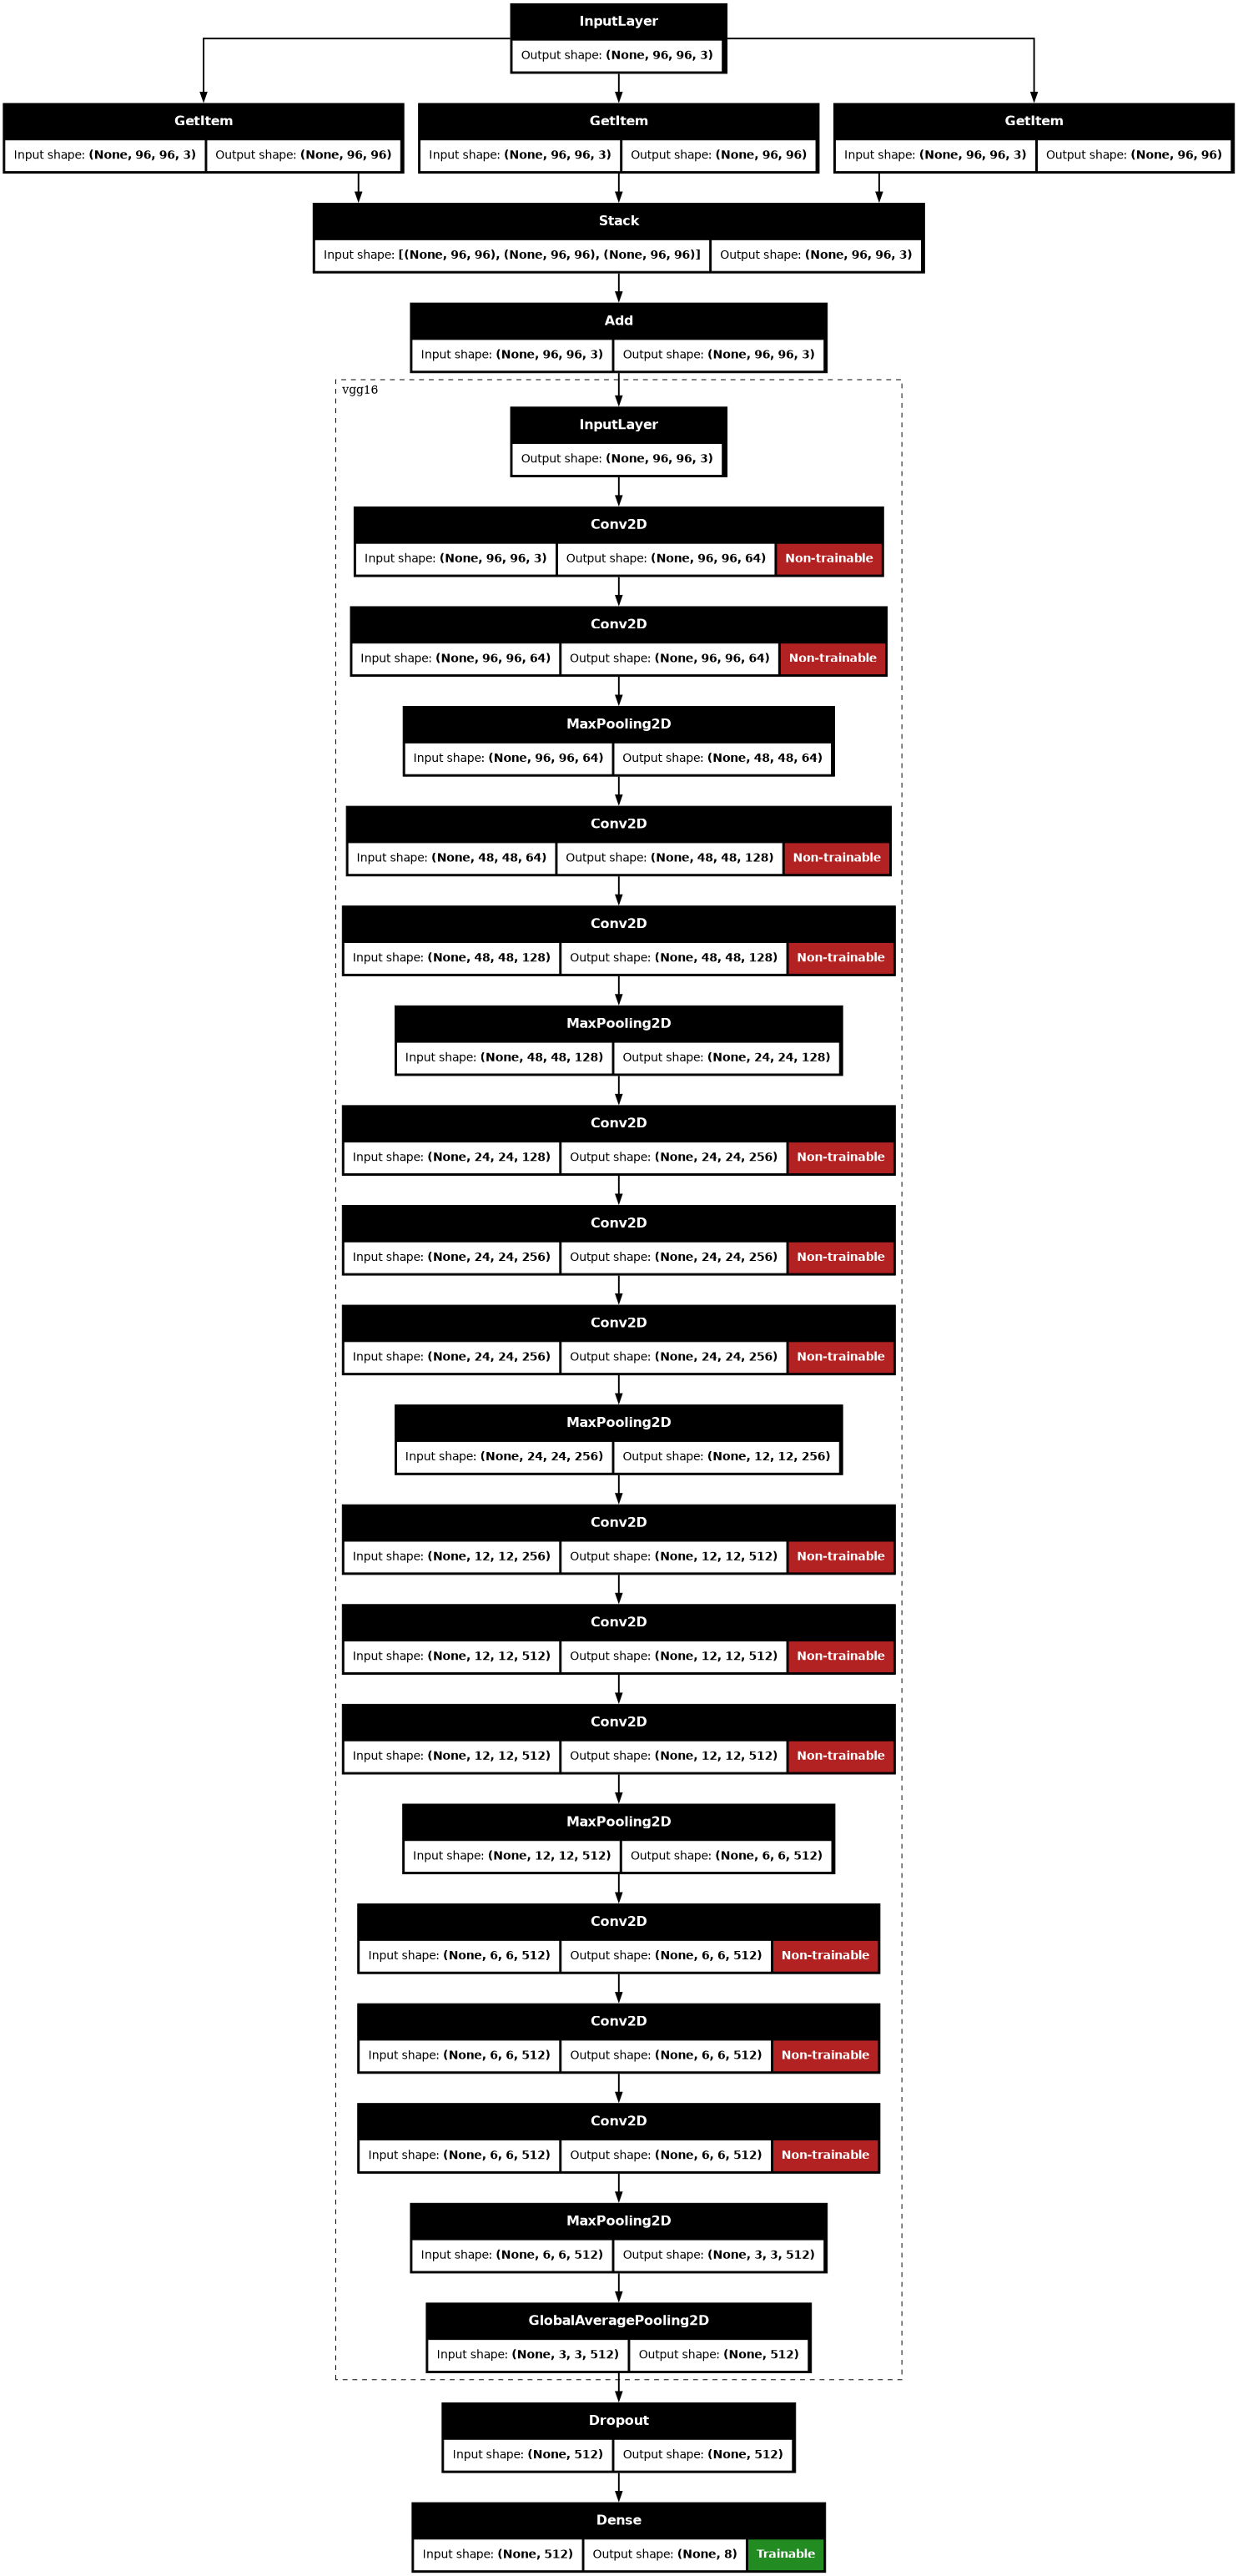

In [49]:
# Display a summary of the model architecture
tl_model1.summary()

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(tl_model1, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

#### Model with 2 dense layer

In [50]:
# Freeze all layers in VGG16 to use it solely as a feature extractor
vgg16.trainable = False

# Define input layer with shape matching the input images
inputs = tfk.Input(shape=input_shape, name='input_layer')

# Pass inputs through the VGG16 feature extractor
x = vgg16(inputs)
print("Shape after VGG16:", x.shape)

# Add a Dense layer without activation
x = tfkl.Dense(512, name='dense1')(x)
print("Shape after Dense1:", x.shape)

# Add Batch Normalization
x = tfkl.BatchNormalization(name='batch_norm1')(x)
print("Shape after BatchNorm1:", x.shape)

# Add ReLU activation
x = tfkl.Activation('relu', name='activation1')(x)
print("Shape after Activation1:", x.shape)

# Add a Dropout layer for regularisation
x = tfkl.Dropout(0.3, name='dropout1')(x)
print("Shape after Dropout1:", x.shape)

# Add final Dense layer for classification with softmax activation
outputs = tfkl.Dense(y_train.shape[-1], activation='softmax', name='dense3')(x)
print("Shape after Dense3:", outputs.shape)

# Define the complete model linking input and output
tl_model2 = tfk.Model(inputs=inputs, outputs=outputs, name='model2')

# Compile the model with categorical cross-entropy loss and Adam optimiser
tl_model2.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])  # default learning rate = 0.001

Shape after VGG16: (None, 512)
Shape after Dense1: (None, 512)
Shape after BatchNorm1: (None, 512)
Shape after Activation1: (None, 512)
Shape after Dropout1: (None, 512)
Shape after Dense3: (None, 8)


Model: "model2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 512)            │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm1                     │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation1 (Activation)        │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense3 (Dense)                  │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,983,496 (57.16 MB)

 Trainable params: 267,784 (1.02 MB)

 Non-trainable params: 14,715,712 (56.14 MB)

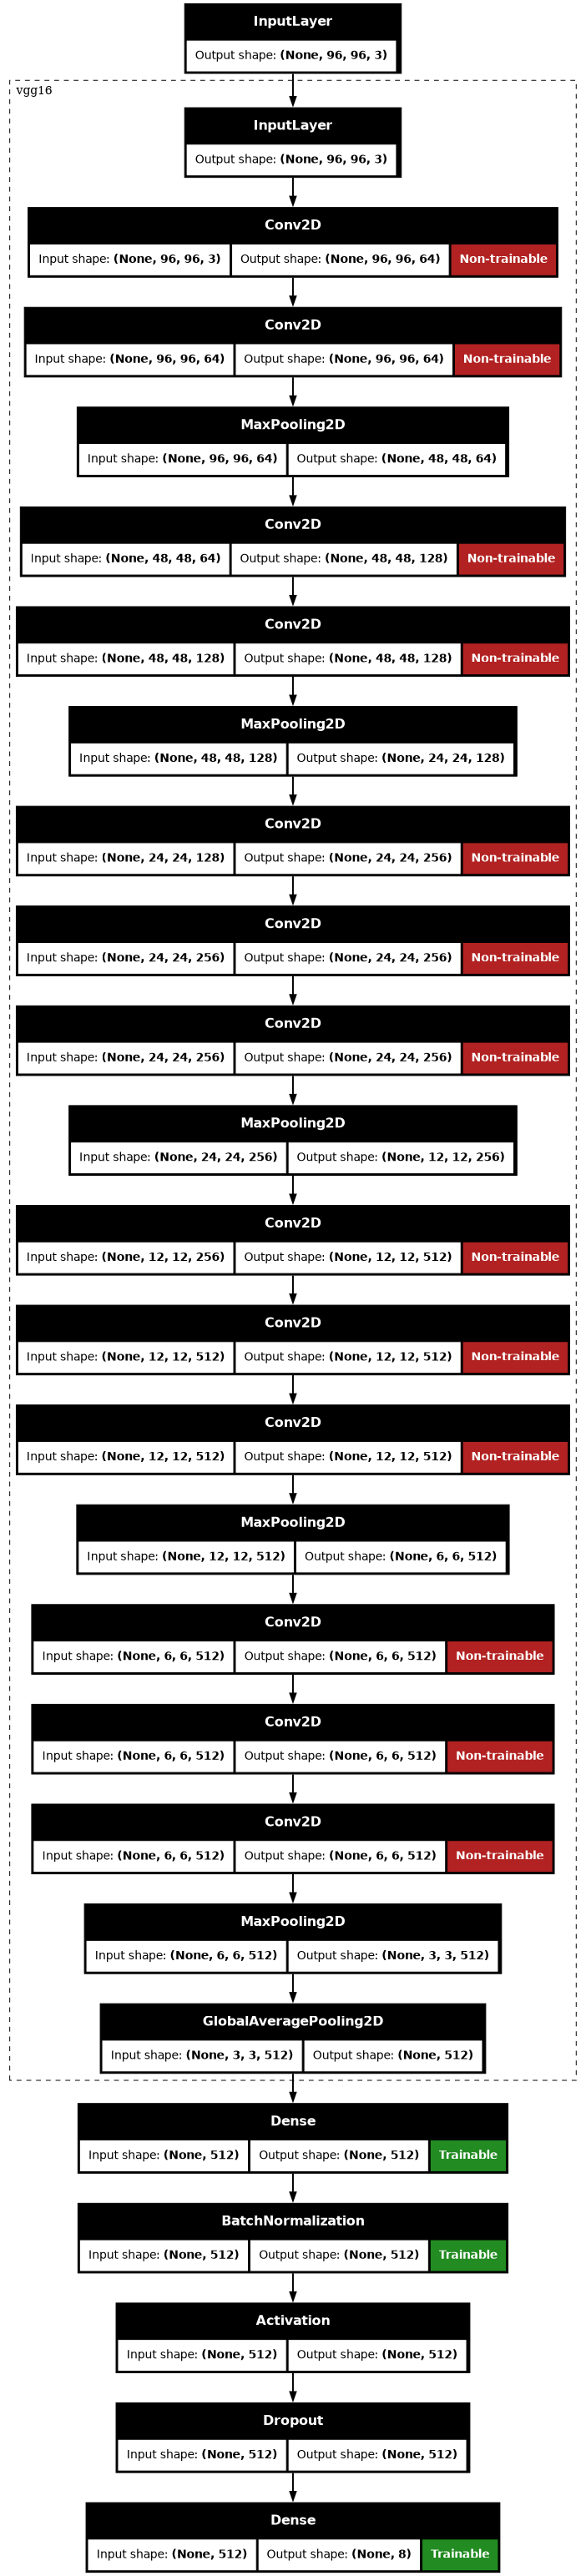

In [51]:
# Display a summary of the model architecture
tl_model2.summary()

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(tl_model2, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

#### Model with 3 dense layers

In [52]:
# Freeze all layers in VGG16 to use it solely as a feature extractor
vgg16.trainable = False

# Define input layer with shape matching the input images
inputs = tfk.Input(shape=input_shape, name='input_layer')

# Pass inputs through the VGG16 feature extractor
x = vgg16(inputs)
print("Shape after VGG16:", x.shape)

# Add a Dense layer without activation
x = tfkl.Dense(512, name='dense1')(x)
print("Shape after Dense1:", x.shape)

# Add Batch Normalization
x = tfkl.BatchNormalization(name='batch_norm1')(x)
print("Shape after BatchNorm1:", x.shape)

# Add ReLU activation
x = tfkl.Activation('relu', name='activation1')(x)
print("Shape after Activation1:", x.shape)

# Add a Dropout layer for regularisation
x = tfkl.Dropout(0.3, name='dropout1')(x)
print("Shape after Dropout1:", x.shape)

# Add another Dense layer without activation
x = tfkl.Dense(256, name='dense2')(x)
print("Shape after Dense2:", x.shape)

# Add Batch Normalization
x = tfkl.BatchNormalization(name='batch_norm2')(x)
print("Shape after BatchNorm2:", x.shape)

# Add ReLU activation
x = tfkl.Activation('relu', name='activation2')(x)
print("Shape after Activation2:", x.shape)

# Add another Dropout layer for regularisation
x = tfkl.Dropout(0.3, name='dropout2')(x)
print("Shape after Dropout2:", x.shape)

# Add final Dense layer for classification with softmax activation
outputs = tfkl.Dense(y_train.shape[-1], activation='softmax', name='dense3')(x)
print("Shape after Dense3:", outputs.shape)

# Define the complete model linking input and output
tl_model3 = tfk.Model(inputs=inputs, outputs=outputs, name='model3')

# Compile the model with categorical cross-entropy loss and Adam optimiser
tl_model3.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])  # default learning rate = 0.001

Shape after VGG16: (None, 512)
Shape after Dense1: (None, 512)
Shape after BatchNorm1: (None, 512)
Shape after Activation1: (None, 512)
Shape after Dropout1: (None, 512)
Shape after Dense2: (None, 256)
Shape after BatchNorm2: (None, 256)
Shape after Activation2: (None, 256)
Shape after Dropout2: (None, 256)
Shape after Dense3: (None, 8)


Model: "model3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 512)            │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm1                     │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation1 (Activation)        │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm2                     │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation2 (Activation)        │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense3 (Dense)                  │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,113,800 (57.65 MB)

 Trainable params: 397,576 (1.52 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

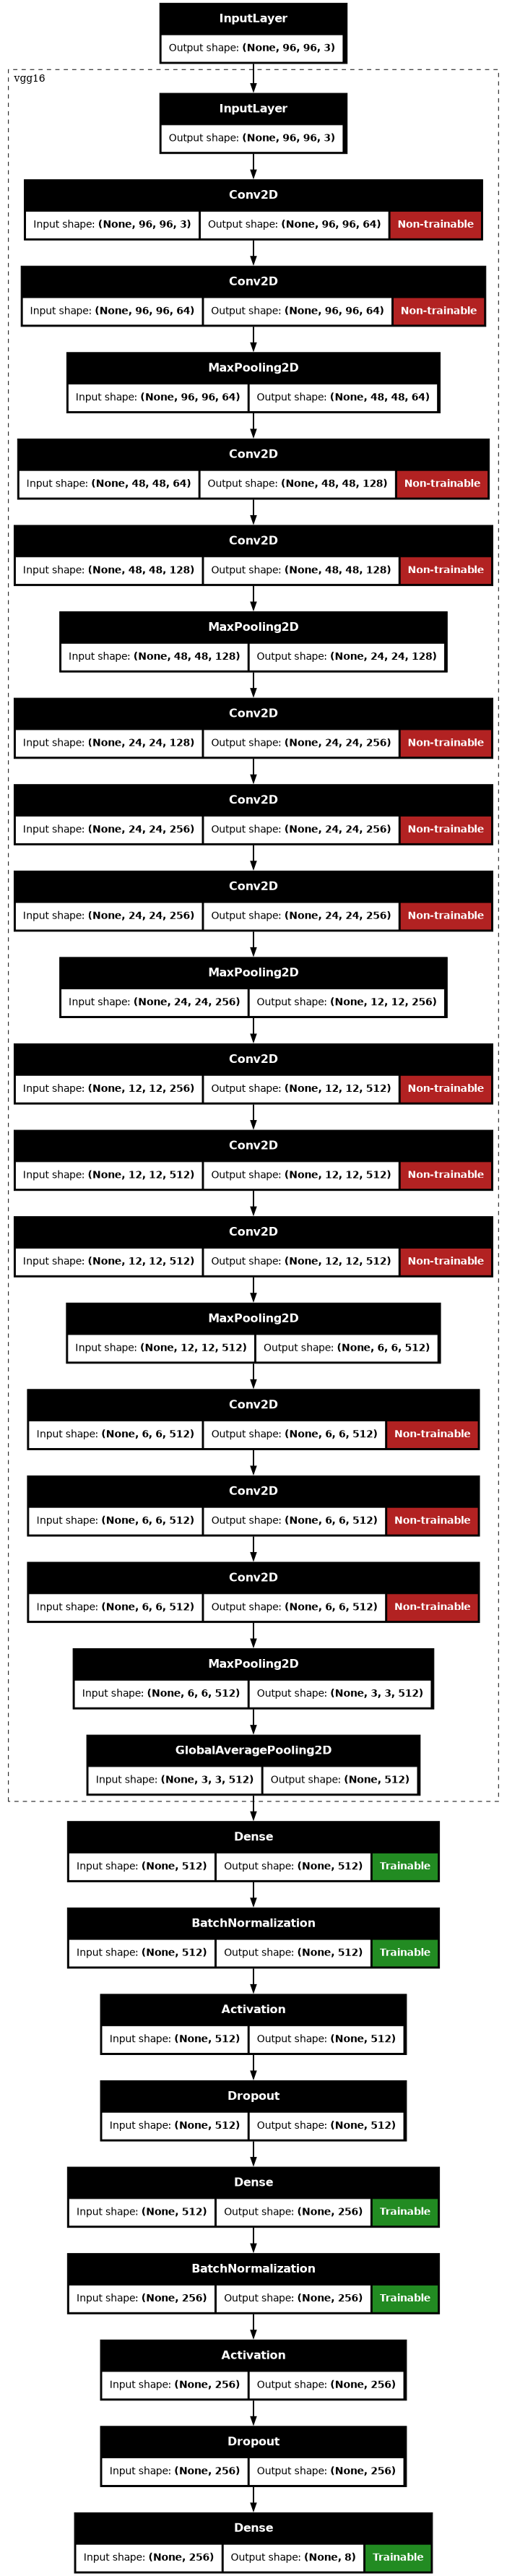

In [53]:
# Display a summary of the model architecture
tl_model3.summary()

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(tl_model3, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [54]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',       # Metric to monitor
    mode='max',                   # Mode ('max' for accuracy)
    patience=20,                  # Number of epochs with no improvement before stopping
    restore_best_weights=True     # Restore the model weights from the epoch with the best value of the monitored metric
)

In [55]:
# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',           # Metric to monitor
    factor=0.5,                   # Factor by which the learning rate will be reduced
    patience=5,                   # Number of epochs with no improvement before reducing learning rate
    verbose=1,                    # Verbosity mode (0 = silent, 1 = updates messages)
    min_lr=1e-6                   # Lower bound on the learning rate
)

In [56]:
# Train the model 1
tl_history1 = tl_model1.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy1 = round(max(tl_history1['val_accuracy']) * 100, 2)
print(f'Final validation accuracy 1: {final_val_accuracy1}%')

# Save the trained model to a file, including final accuracy in the filename
model_filename = f'VGG1_{final_val_accuracy1}.keras'
tl_model1.save(model_filename)

# Free memory by deleting the model instance
del tl_model1

Epoch 1/200


I0000 00:00:1732460815.909751      78 service.cc:145] XLA service 0x7950b404ea60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732460815.909818      78 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  5/337 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.1175 - loss: 17.7146

I0000 00:00:1732460821.629309      78 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


337/337 ━━━━━━━━━━━━━━━━━━━━ 25s 55ms/step - accuracy: 0.2264 - loss: 7.9654 - val_accuracy: 0.4934 - val_loss: 1.9818 - learning_rate: 0.0010
Epoch 2/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.4220 - loss: 2.6552 - val_accuracy: 0.5425 - val_loss: 1.4164 - learning_rate: 0.0010
Epoch 3/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.4737 - loss: 1.8033 - val_accuracy: 0.5593 - val_loss: 1.2925 - learning_rate: 0.0010
Epoch 4/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.4898 - loss: 1.5717 - val_accuracy: 0.5536 - val_loss: 1.2902 - learning_rate: 0.0010
Epoch 5/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.4826 - loss: 1.5529 - val_accuracy: 0.5547 - val_loss: 1.2815 - learning_rate: 0.0010
Epoch 6/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.4844 - loss: 1.5269 - val_accuracy: 0.5579 - val_loss: 1.2861 - learning_rate: 0.0010
Epoch 7/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.4776 - loss: 

In [57]:
# Train the model 2
tl_history2 = tl_model2.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy2 = round(max(tl_history2['val_accuracy']) * 100, 2)
print(f'Final validation accuracy 2: {final_val_accuracy2}%')

# Save the trained model to a file, including final accuracy in the filename
model_filename = f'VGG2_{final_val_accuracy2}.keras'
tl_model2.save(model_filename)

# Free memory by deleting the model instance
del tl_model2

Epoch 1/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.3972 - loss: 1.7065 - val_accuracy: 0.5593 - val_loss: 1.2176 - learning_rate: 0.0010
Epoch 2/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.5616 - loss: 1.2198 - val_accuracy: 0.5708 - val_loss: 1.1766 - learning_rate: 0.0010
Epoch 3/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.6076 - loss: 1.0992 - val_accuracy: 0.5837 - val_loss: 1.1476 - learning_rate: 0.0010
Epoch 4/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.6352 - loss: 1.0122 - val_accuracy: 0.5862 - val_loss: 1.1466 - learning_rate: 0.0010
Epoch 5/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.6598 - loss: 0.9462 - val_accuracy: 0.5889 - val_loss: 1.1472 - learning_rate: 0.0010
Epoch 6/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.6727 - loss: 0.8924 - val_accuracy: 0.5975 - val_loss: 1.1403 - learning_rate: 0.0010
Epoch 7/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.6

In [58]:
# Train the model 3
tl_history3 = tl_model3.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy3 = round(max(tl_history3['val_accuracy']) * 100, 2)
print(f'Final validation accuracy 3: {final_val_accuracy3}%')

# Save the trained model to a file, including final accuracy in the filename
model_filename = f'VGG3_{final_val_accuracy3}.keras'
tl_model3.save(model_filename)

# Free memory by deleting the model instance
del tl_model3

Epoch 1/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 24s 55ms/step - accuracy: 0.3565 - loss: 1.7878 - val_accuracy: 0.5307 - val_loss: 1.2633 - learning_rate: 0.0010
Epoch 2/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.5232 - loss: 1.3079 - val_accuracy: 0.5752 - val_loss: 1.1541 - learning_rate: 0.0010
Epoch 3/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.5700 - loss: 1.1808 - val_accuracy: 0.5868 - val_loss: 1.1201 - learning_rate: 0.0010
Epoch 4/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.5955 - loss: 1.0938 - val_accuracy: 0.5829 - val_loss: 1.1382 - learning_rate: 0.0010
Epoch 5/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.6257 - loss: 1.0254 - val_accuracy: 0.5833 - val_loss: 1.1421 - learning_rate: 0.0010
Epoch 6/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.6352 - loss: 0.9707 - val_accuracy: 0.5942 - val_loss: 1.1265 - learning_rate: 0.0010
Epoch 7/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.6

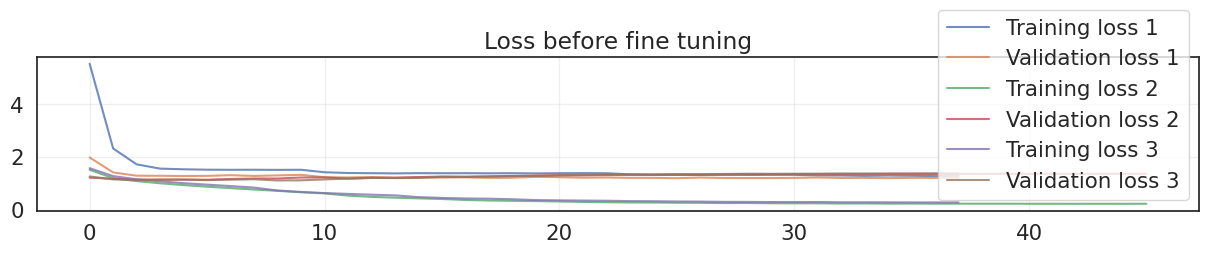

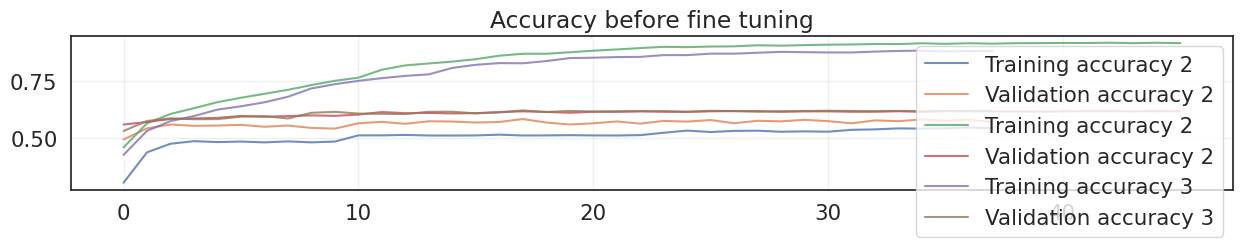

In [59]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(tl_history1['loss'], label='Training loss 1', alpha=.8)
plt.plot(tl_history1['val_loss'], label='Validation loss 1', alpha=.8)
plt.plot(tl_history2['loss'], label='Training loss 2', alpha=.8)
plt.plot(tl_history2['val_loss'], label='Validation loss 2', alpha=.8)
plt.plot(tl_history3['loss'], label='Training loss 3', alpha=.8)
plt.plot(tl_history3['val_loss'], label='Validation loss 3', alpha=.8)
plt.title('Loss before fine tuning')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(tl_history1['accuracy'], label='Training accuracy 2', alpha=.8)
plt.plot(tl_history1['val_accuracy'], label='Validation accuracy 2', alpha=.8)
plt.plot(tl_history2['accuracy'], label='Training accuracy 2', alpha=.8)
plt.plot(tl_history2['val_accuracy'], label='Validation accuracy 2', alpha=.8)
plt.plot(tl_history3['accuracy'], label='Training accuracy 3', alpha=.8)
plt.plot(tl_history3['val_accuracy'], label='Validation accuracy 3', alpha=.8)
plt.title('Accuracy before fine tuning')
plt.legend()
plt.grid(alpha=.3)

plt.show()

## 🛠️ Fine Tuning















<img src="https://www.researchgate.net/publication/359405075/figure/fig2/AS:1182999492214798@1659060466845/Concept-of-fine-tuning-and-feature-extraction_W640.jpg" width="700"/>


In [61]:
# Re-load the model after transfer learning
ft_model1 = tfk.models.load_model('/kaggle/working/VGG1_58.37.keras') # model 1
ft_model2 = tfk.models.load_model('/kaggle/working/VGG2_62.0.keras') # model 2
ft_model3 = tfk.models.load_model('/kaggle/working/VGG3_62.21.keras') # model 3

In [62]:
# Set the Xception model layers as trainable
ft_model1.get_layer('vgg16').trainable = True
ft_model2.get_layer('vgg16').trainable = True
ft_model3.get_layer('vgg16').trainable = True

In [63]:
# Set the number of layers to freeze
N = 13  # adjust based on your model

# Set the first N layers as non-trainable
for i, layer in enumerate(ft_model1.get_layer('vgg16').layers[:N]):
    layer.trainable = False

for layer in ft_model1.get_layer('vgg16').layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

# Set the first N layers as non-trainable
for i, layer in enumerate(ft_model2.get_layer('vgg16').layers[:N]):
    layer.trainable = False

for layer in ft_model2.get_layer('vgg16').layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

for i, layer in enumerate(ft_model3.get_layer('vgg16').layers[:N]):
    layer.trainable = False

for layer in ft_model3.get_layer('vgg16').layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

# Print layer indices, names, and trainability status
for i, layer in enumerate(ft_model1.get_layer('vgg16').layers):
    print(i, layer.name, layer.trainable)
    
for i, layer in enumerate(ft_model2.get_layer('vgg16').layers):
    print(i, layer.name, layer.trainable)

for i, layer in enumerate(ft_model3.get_layer('vgg16').layers):
    print(i, layer.name, layer.trainable)

0 input_layer_2 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
19 global_average_pooling2d_2 True
0 input_layer_2 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
19 global_average_pooling2d_2 True
0 input_layer_2 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2

Model: "model1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_6          │ (None, 96, 96)    │          0 │ input_layer[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_7          │ (None, 96, 96)    │          0 │ input_layer[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_8          │ (None, 96, 96)    │          0 │ input_layer[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_3 (Stack)     │ (None, 96, 96, 3) │          0 │ get_item_6[0][0], │
│                     │                   │            │ get_item_7[0][0], │
│                     │                   │            │ get_item_8[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 96, 96, 3) │          0 │ stack_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 512)       │ 14,714,688 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └ input_layer_2  │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └ block1_conv1   │ (None, 96, 96,    │      1,792 │ -                 │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └ block1_conv2   │ (None, 96, 96,    │     36,928 │ -                 │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └ block1_pool    │ (None, 48, 48,    │          0 │ -                 │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └ block2_conv1   │ (None, 48, 48,    │     73,856 │ -                 │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └ block2_conv2   │ (None, 48, 48,    │    147,584 │ -                 │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └ block2_pool    │ (None, 24, 24,    │          0 │ -                 │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └ block3_conv1   │ (None, 24, 24,    │    295,168 │ -                 │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └ block3_conv2   │ (None, 24, 24,    │    590,080 │ -                 │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│    └ block3_conv3   │ (None, 24, 24,    │    590,080 │ -                 │
│ (Conv2D)            │ 256)              │            │                 

 Total params: 14,727,002 (56.18 MB)

 Trainable params: 9,443,336 (36.02 MB)

 Non-trainable params: 5,275,456 (20.12 MB)

 Optimizer params: 8,210 (32.07 KB)

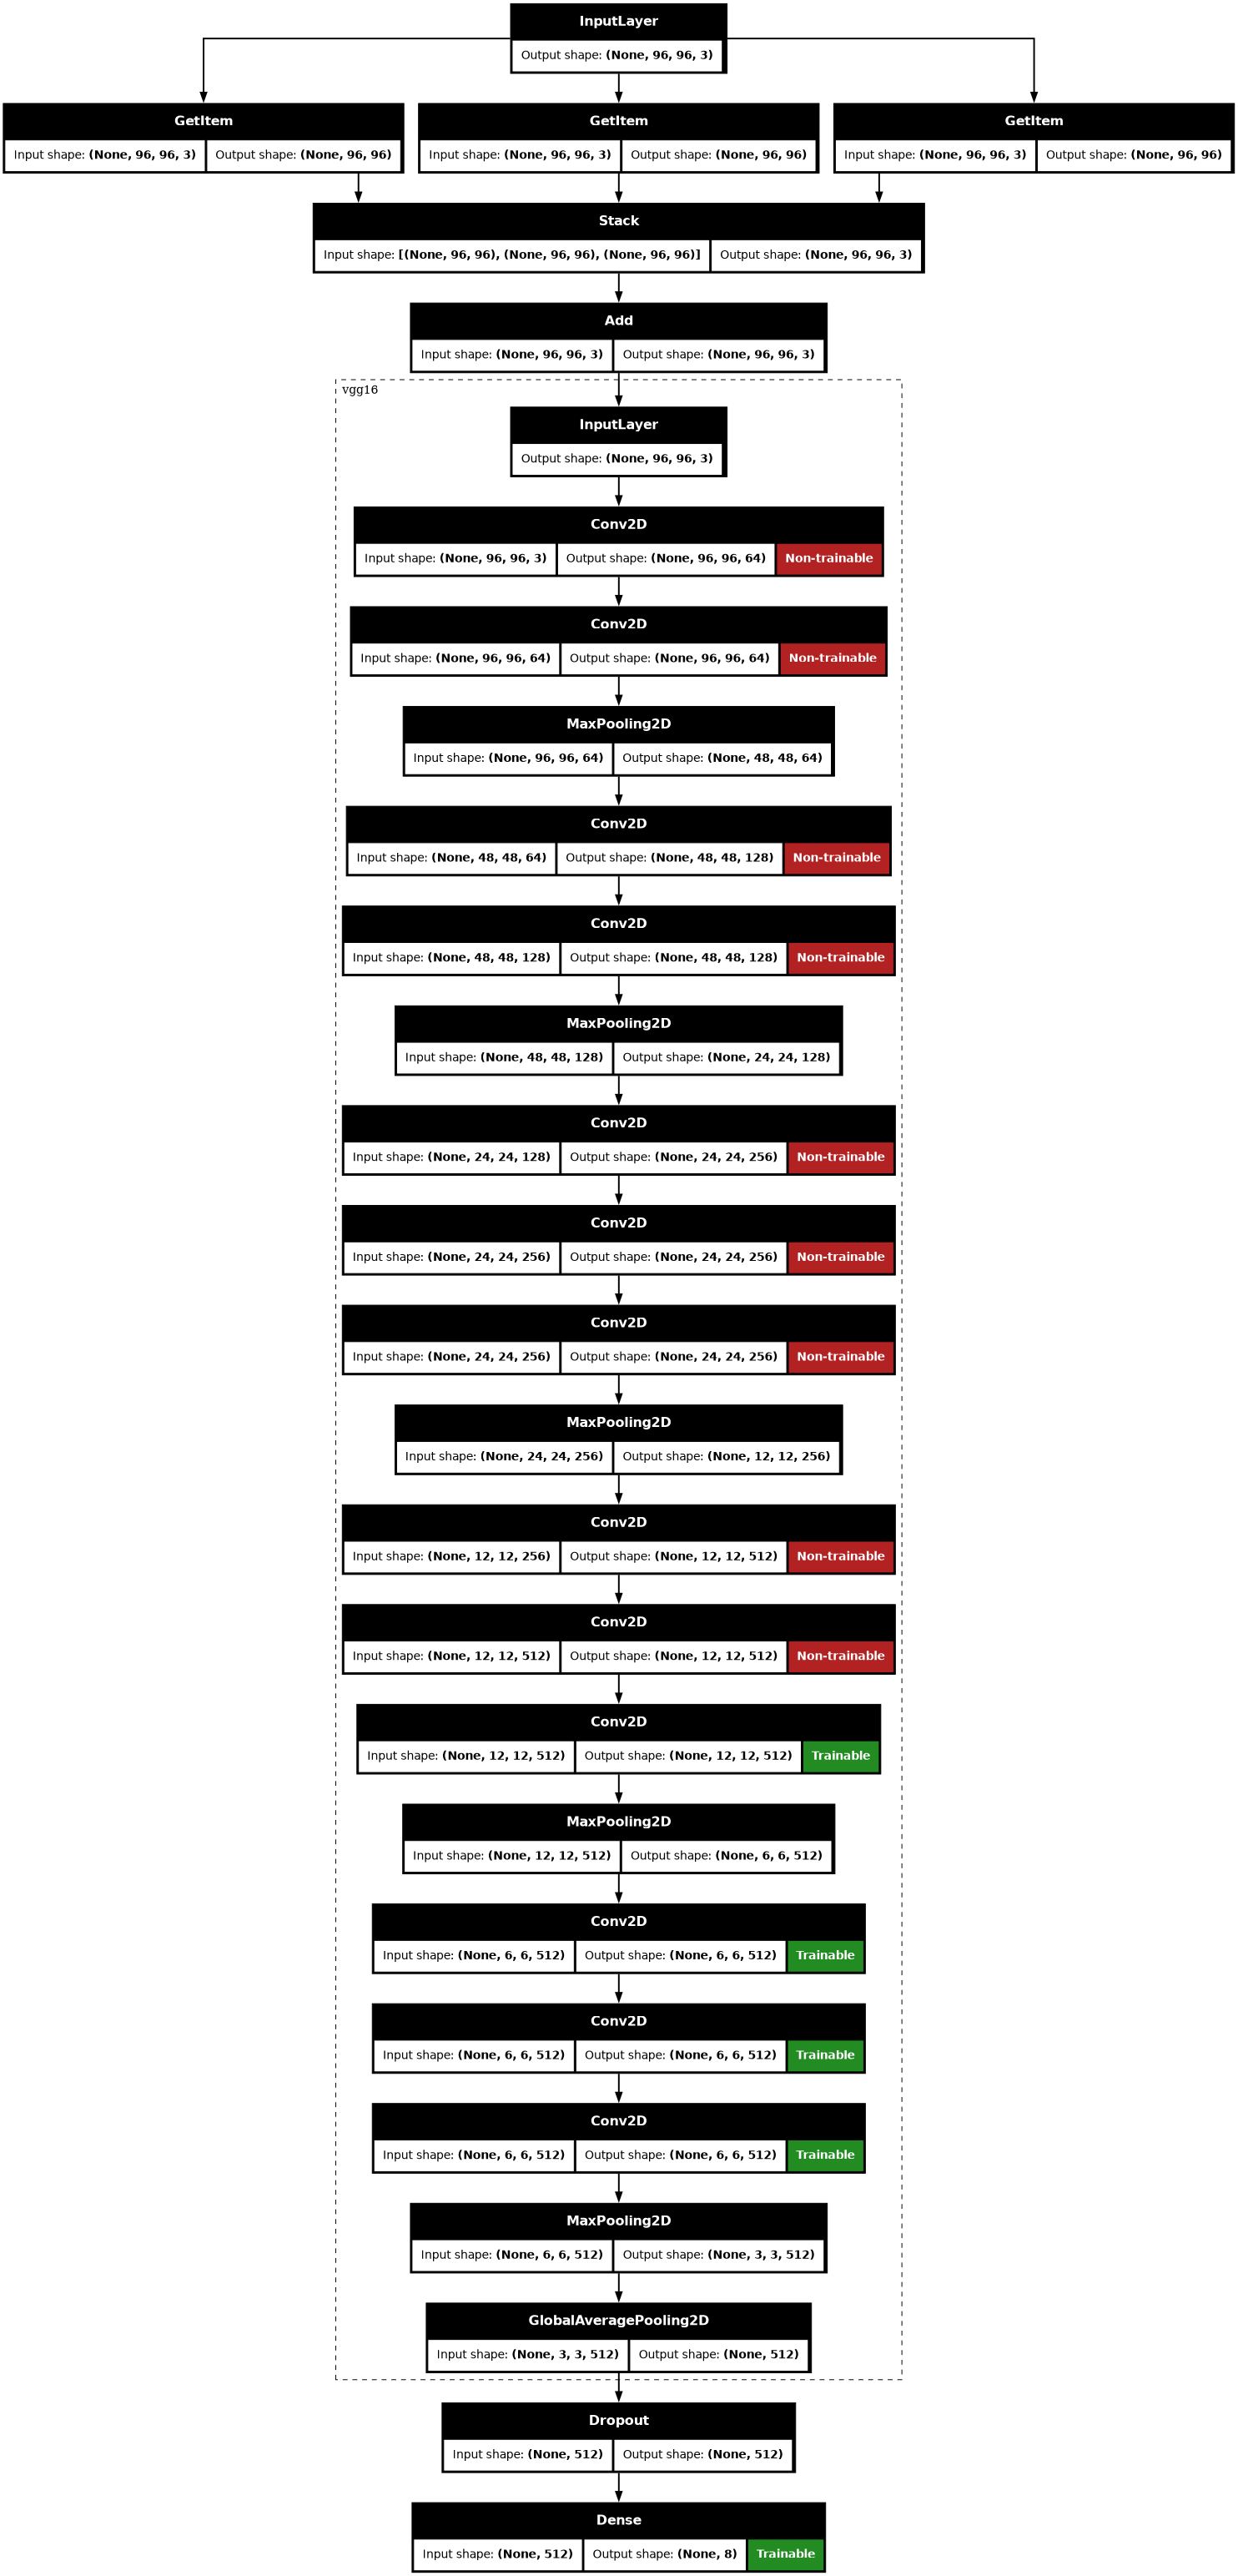

In [64]:
# Display a summary of the model 1 architecture
ft_model1.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(ft_model1, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

Model: "model2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 512)            │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ input_layer_2 (InputLayer) │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block1_conv1 (Conv2D)      │ (None, 96, 96, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block1_conv2 (Conv2D)      │ (None, 96, 96, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block1_pool (MaxPooling2D) │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block2_conv1 (Conv2D)      │ (None, 48, 48, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block2_conv2 (Conv2D)      │ (None, 48, 48, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block2_pool (MaxPooling2D) │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block3_conv1 (Conv2D)      │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block3_conv2 (Conv2D)      │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block3_conv3 (Conv2D)      │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block3_pool (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block4_conv1 (Conv2D)      │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block4_conv2 (Conv2D)      │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block4_conv3 (Conv2D)      │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block4_pool (MaxPooling2D) │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block5_conv1 (Conv2D)      │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block5_conv2 (Conv2D)      │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block5_conv3 (Conv2D)      │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block5_pool (MaxPooling2D) │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ global_average_pooling2d_2 │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm1                     │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │             

 Total params: 15,519,066 (59.20 MB)

 Trainable params: 9,707,016 (37.03 MB)

 Non-trainable params: 5,276,480 (20.13 MB)

 Optimizer params: 535,570 (2.04 MB)

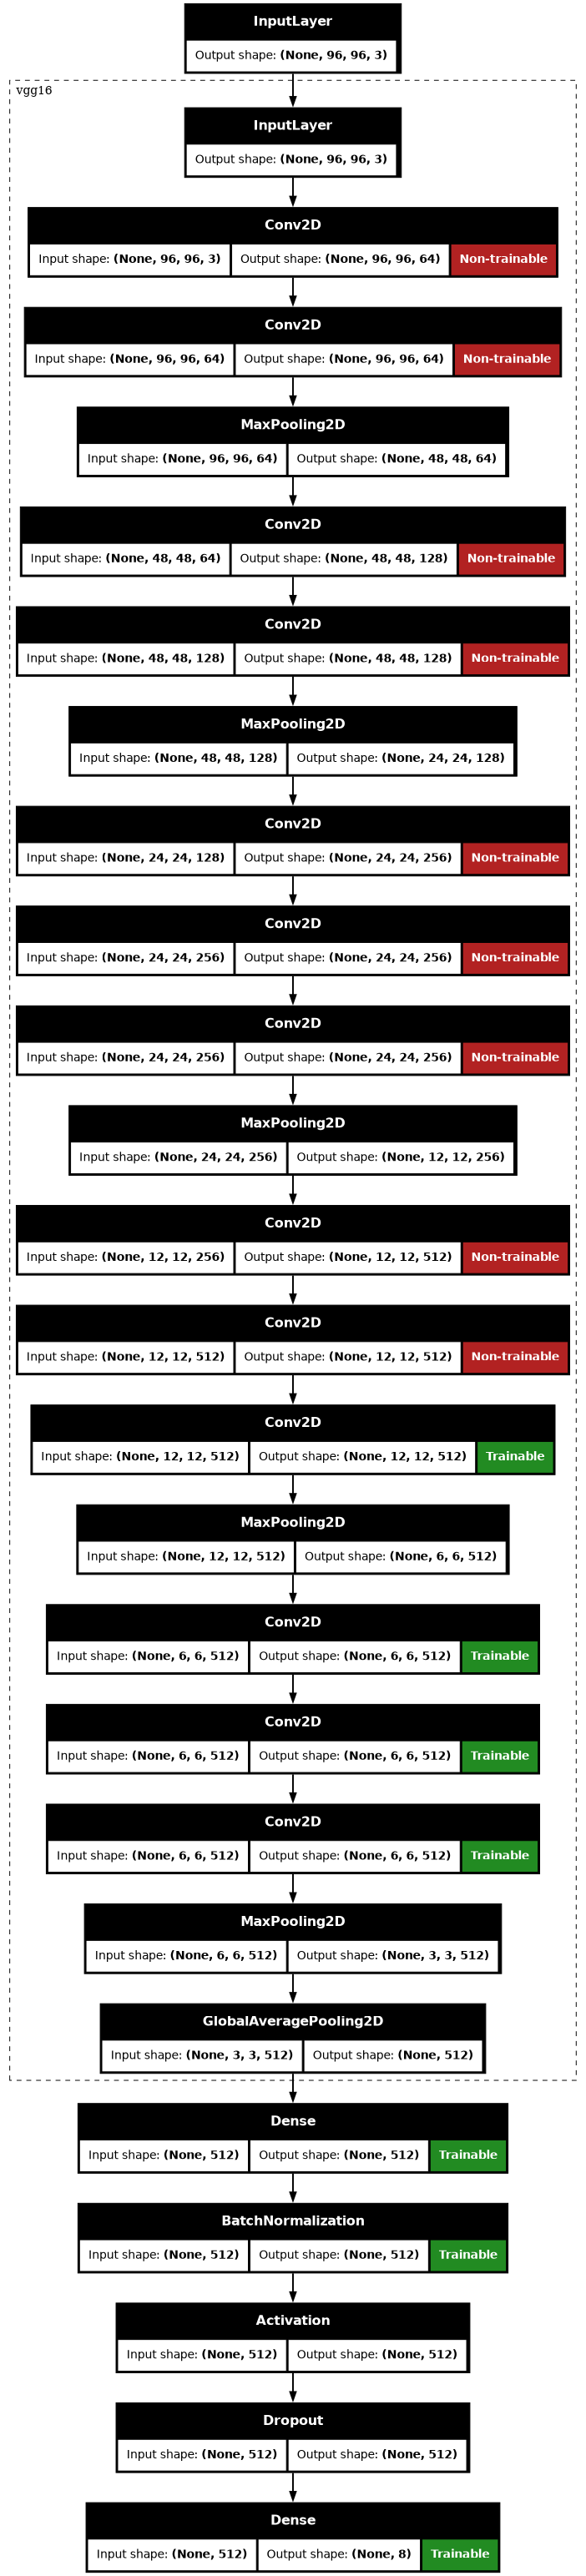

In [65]:
# Display a summary of the model 2 architecture
ft_model2.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(ft_model2, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

Model: "model3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 512)            │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ input_layer_2 (InputLayer) │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block1_conv1 (Conv2D)      │ (None, 96, 96, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block1_conv2 (Conv2D)      │ (None, 96, 96, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block1_pool (MaxPooling2D) │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block2_conv1 (Conv2D)      │ (None, 48, 48, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block2_conv2 (Conv2D)      │ (None, 48, 48, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block2_pool (MaxPooling2D) │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block3_conv1 (Conv2D)      │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block3_conv2 (Conv2D)      │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block3_conv3 (Conv2D)      │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block3_pool (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block4_conv1 (Conv2D)      │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block4_conv2 (Conv2D)      │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block4_conv3 (Conv2D)      │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block4_pool (MaxPooling2D) │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block5_conv1 (Conv2D)      │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block5_conv2 (Conv2D)      │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block5_conv3 (Conv2D)      │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block5_pool (MaxPooling2D) │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ global_average_pooling2d_2 │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm1                     │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │             

 Total params: 15,908,954 (60.69 MB)

 Trainable params: 9,836,808 (37.52 MB)

 Non-trainable params: 5,276,992 (20.13 MB)

 Optimizer params: 795,154 (3.03 MB)

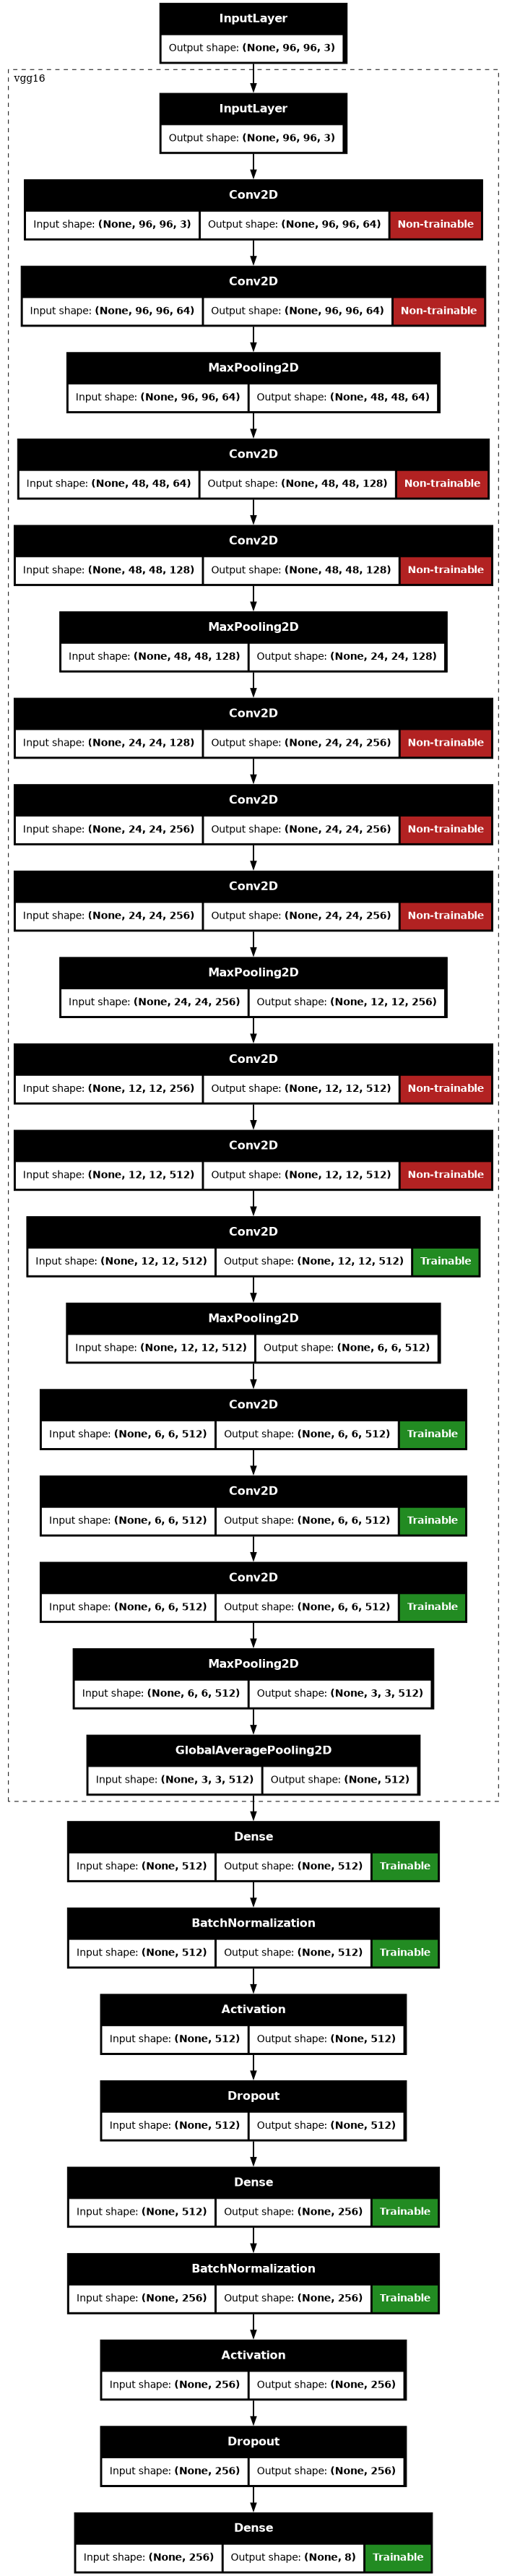

In [66]:
# Display a summary of the model 3 architecture
ft_model3.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(ft_model3, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [68]:
# Compile the model
ft_model1.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy'])
ft_model2.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy'])
ft_model3.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy'])

In [69]:
# Fine-tune the model 1
ft_history1 = ft_model1.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
).history

# Calculate and print the final validation accuracy
final_val_accuracy1 = round(max(ft_history1['val_accuracy']) * 100, 2)
print(f'Final validation accuracy 1: {final_val_accuracy1}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'VGGFT1_' + str(final_val_accuracy1) + '.keras'
ft_model1.save(model_filename)

# Delete the model to free up resources
del ft_model1

Epoch 1/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 26s 63ms/step - accuracy: 0.5746 - loss: 1.2107 - val_accuracy: 0.6853 - val_loss: 0.8465 - learning_rate: 1.0000e-04
Epoch 2/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.7590 - loss: 0.6742 - val_accuracy: 0.7655 - val_loss: 0.6634 - learning_rate: 1.0000e-04
Epoch 3/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - accuracy: 0.8324 - loss: 0.4553 - val_accuracy: 0.7627 - val_loss: 0.7381 - learning_rate: 1.0000e-04
Epoch 4/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.8732 - loss: 0.3329 - val_accuracy: 0.7927 - val_loss: 0.7086 - learning_rate: 1.0000e-04
Epoch 5/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.8972 - loss: 0.2896 - val_accuracy: 0.7888 - val_loss: 0.6901 - learning_rate: 1.0000e-04
Epoch 6/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.9198 - loss: 0.2210 - val_accuracy: 0.7887 - val_loss: 0.7571 - learning_rate: 1.0000e-04
Epoch 7/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 40

In [70]:
# Fine-tune the model 2
ft_history2 = ft_model2.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
).history

# Calculate and print the final validation accuracy
final_val_accuracy2 = round(max(ft_history2['val_accuracy']) * 100, 2)
print(f'Final validation accuracy 2: {final_val_accuracy2}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'VGGFT2_' + str(final_val_accuracy2) + '.keras'
ft_model2.save(model_filename)

# Delete the model to free up resources
del ft_model2

Epoch 1/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - accuracy: 0.6326 - loss: 1.2711 - val_accuracy: 0.6543 - val_loss: 1.1681 - learning_rate: 1.0000e-04
Epoch 2/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - accuracy: 0.7682 - loss: 0.6675 - val_accuracy: 0.7049 - val_loss: 0.9397 - learning_rate: 1.0000e-04
Epoch 3/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - accuracy: 0.8440 - loss: 0.4290 - val_accuracy: 0.7396 - val_loss: 0.9088 - learning_rate: 1.0000e-04
Epoch 4/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.8980 - loss: 0.2742 - val_accuracy: 0.7627 - val_loss: 0.8992 - learning_rate: 1.0000e-04
Epoch 5/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.9190 - loss: 0.2093 - val_accuracy: 0.7332 - val_loss: 1.1059 - learning_rate: 1.0000e-04
Epoch 6/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.9386 - loss: 0.1669 - val_accuracy: 0.7407 - val_loss: 1.2525 - learning_rate: 1.0000e-04
Epoch 7/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 16s 4

In [71]:
# Fine-tune the model 3
ft_history3 = ft_model3.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
).history

# Calculate and print the final validation accuracy
final_val_accuracy3 = round(max(ft_history3['val_accuracy']) * 100, 2)
print(f'Final validation accuracy 3: {final_val_accuracy3}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'VGGFT3_' + str(final_val_accuracy3) + '.keras'
ft_model3.save(model_filename)

# Delete the model to free up resources
del ft_model3

Epoch 1/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 29s 67ms/step - accuracy: 0.6254 - loss: 1.2601 - val_accuracy: 0.6858 - val_loss: 0.8947 - learning_rate: 1.0000e-04
Epoch 2/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.7543 - loss: 0.6630 - val_accuracy: 0.7114 - val_loss: 0.8221 - learning_rate: 1.0000e-04
Epoch 3/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - accuracy: 0.8290 - loss: 0.4461 - val_accuracy: 0.7393 - val_loss: 0.7696 - learning_rate: 1.0000e-04
Epoch 4/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.8860 - loss: 0.3006 - val_accuracy: 0.7518 - val_loss: 0.8160 - learning_rate: 1.0000e-04
Epoch 5/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.9071 - loss: 0.2432 - val_accuracy: 0.7464 - val_loss: 0.9173 - learning_rate: 1.0000e-04
Epoch 6/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - accuracy: 0.9314 - loss: 0.1823 - val_accuracy: 0.7429 - val_loss: 0.9769 - learning_rate: 1.0000e-04
Epoch 7/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 17s 5

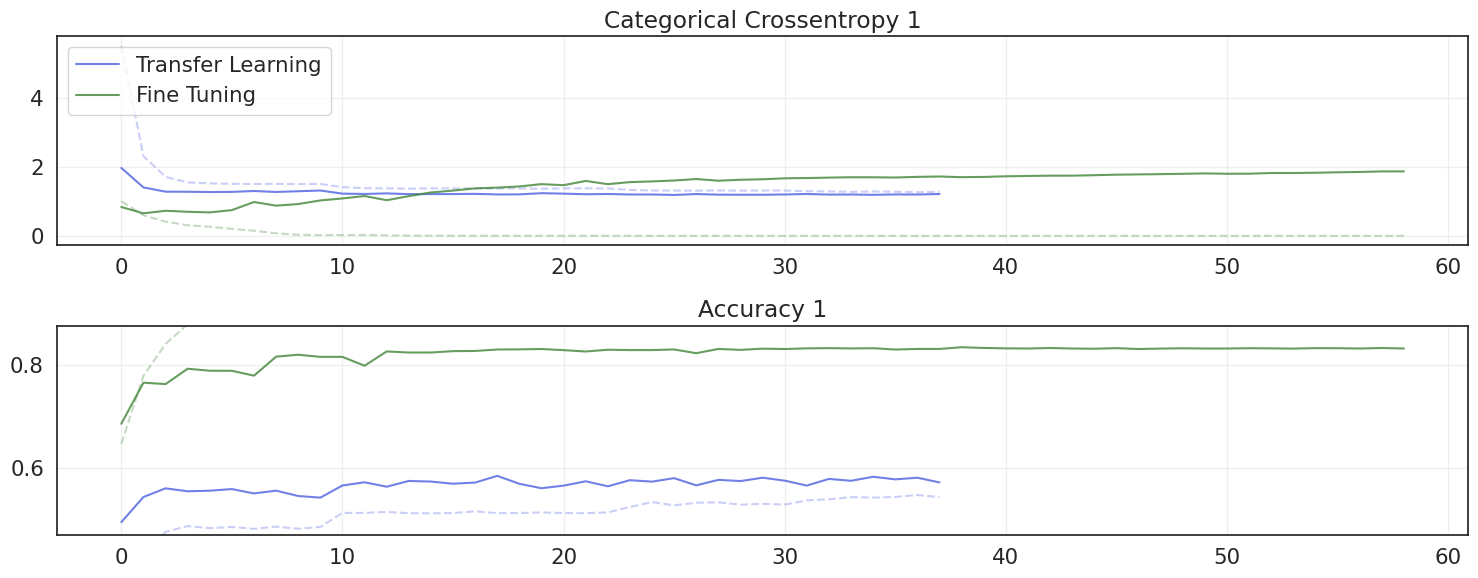

In [72]:
# Create figure and subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6))

# Plot categorical cross-entropy loss for both Transfer Learning and Fine Tuning stages
ax1.plot(tl_history1['loss'], alpha=0.3, color='#4D61E2', linestyle='--')
ax1.plot(tl_history1['val_loss'], label='Transfer Learning', alpha=0.8, color='#4D61E2')
ax1.plot(ft_history1['loss'], alpha=0.3, color='#408537', linestyle='--')
ax1.plot(ft_history1['val_loss'], label='Fine Tuning', alpha=0.8, color='#408537')
ax1.set_title('Categorical Crossentropy 1')
ax1.legend(loc='upper left')
ax1.grid(alpha=0.3)

# Plot accuracy for both Transfer Learning and Fine Tuning stages
ax2.plot(tl_history1['accuracy'], alpha=0.3, color='#4D61E2', linestyle='--')
ax2.plot(tl_history1['val_accuracy'], label='Transfer Learning', alpha=0.8, color='#4D61E2')
ax2.plot(ft_history1['accuracy'], alpha=0.3, color='#408537', linestyle='--')
ax2.plot(ft_history1['val_accuracy'], label='Fine Tuning', alpha=0.8, color='#408537')
ax2.set_title('Accuracy 1')
ax2.set_ylim([min(tl_history1['val_accuracy']) * 0.95, max(ft_history1['val_accuracy']) * 1.05])
ax2.grid(alpha=0.3)

# Adjust layout to prevent overlap and display the plots
plt.tight_layout()
plt.show()

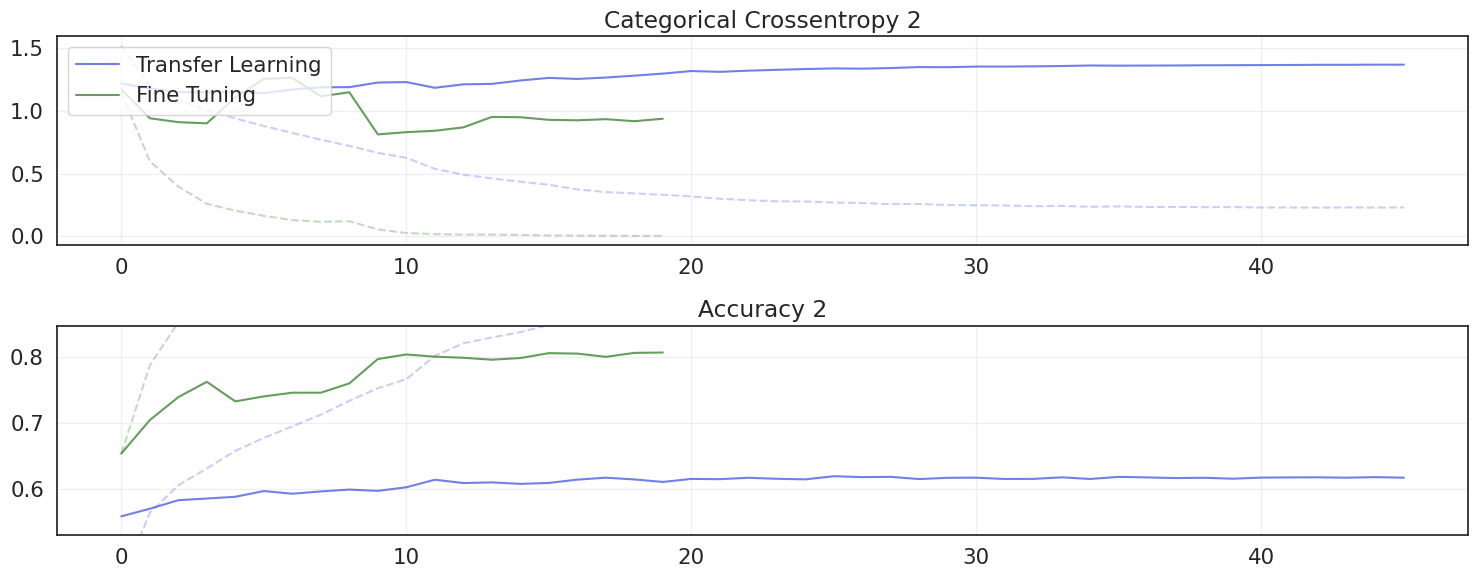

In [74]:
# Create figure and subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6))

# Plot categorical cross-entropy loss for both Transfer Learning and Fine Tuning stages
ax1.plot(tl_history2['loss'], alpha=0.3, color='#4D61E2', linestyle='--')
ax1.plot(tl_history2['val_loss'], label='Transfer Learning', alpha=0.8, color='#4D61E2')
ax1.plot(ft_history2['loss'], alpha=0.3, color='#408537', linestyle='--')
ax1.plot(ft_history2['val_loss'], label='Fine Tuning', alpha=0.8, color='#408537')
ax1.set_title('Categorical Crossentropy 2')
ax1.legend(loc='upper left')
ax1.grid(alpha=0.3)

# Plot accuracy for both Transfer Learning and Fine Tuning stages
ax2.plot(tl_history2['accuracy'], alpha=0.3, color='#4D61E2', linestyle='--')
ax2.plot(tl_history2['val_accuracy'], label='Transfer Learning', alpha=0.8, color='#4D61E2')
ax2.plot(ft_history2['accuracy'], alpha=0.3, color='#408537', linestyle='--')
ax2.plot(ft_history2['val_accuracy'], label='Fine Tuning', alpha=0.8, color='#408537')
ax2.set_title('Accuracy 2')
ax2.set_ylim([min(tl_history2['val_accuracy']) * 0.95, max(ft_history2['val_accuracy']) * 1.05])
ax2.grid(alpha=0.3)

# Adjust layout to prevent overlap and display the plots
plt.tight_layout()
plt.show()

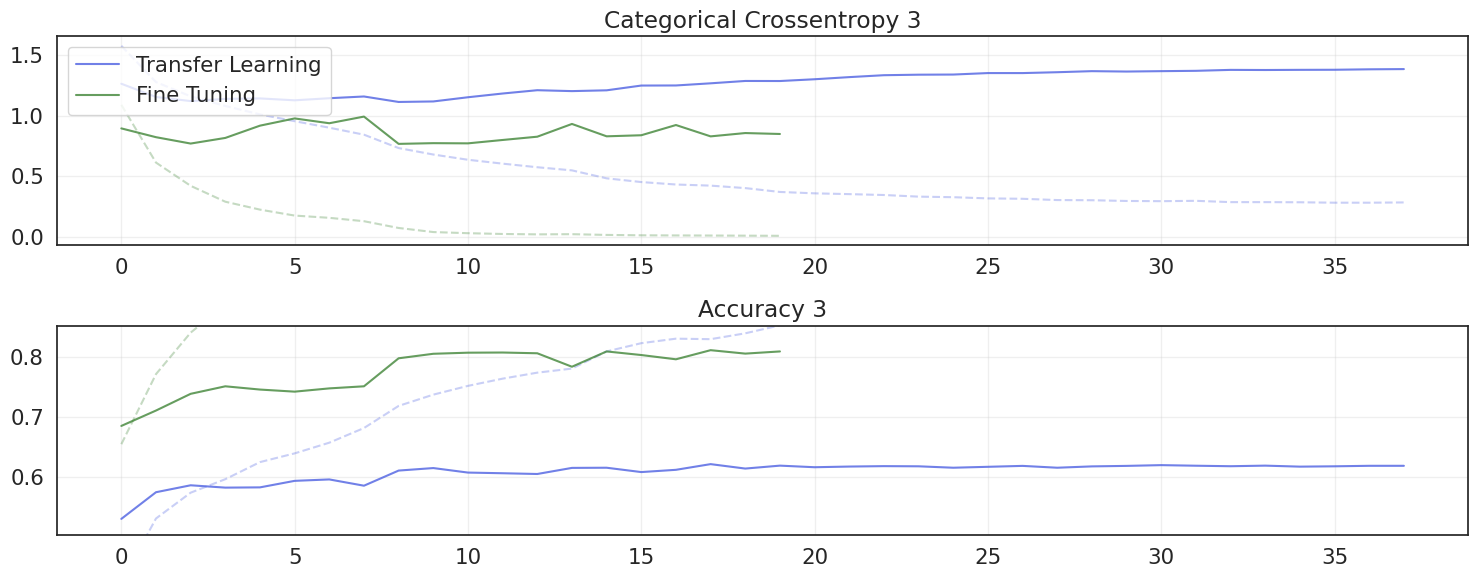

In [75]:
# Create figure and subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6))

# Plot categorical cross-entropy loss for both Transfer Learning and Fine Tuning stages
ax1.plot(tl_history3['loss'], alpha=0.3, color='#4D61E2', linestyle='--')
ax1.plot(tl_history3['val_loss'], label='Transfer Learning', alpha=0.8, color='#4D61E2')
ax1.plot(ft_history3['loss'], alpha=0.3, color='#408537', linestyle='--')
ax1.plot(ft_history3['val_loss'], label='Fine Tuning', alpha=0.8, color='#408537')
ax1.set_title('Categorical Crossentropy 3')
ax1.legend(loc='upper left')
ax1.grid(alpha=0.3)

# Plot accuracy for both Transfer Learning and Fine Tuning stages
ax2.plot(tl_history3['accuracy'], alpha=0.3, color='#4D61E2', linestyle='--')
ax2.plot(tl_history3['val_accuracy'], label='Transfer Learning', alpha=0.8, color='#4D61E2')
ax2.plot(ft_history3['accuracy'], alpha=0.3, color='#408537', linestyle='--')
ax2.plot(ft_history3['val_accuracy'], label='Fine Tuning', alpha=0.8, color='#408537')
ax2.set_title('Accuracy 3')
ax2.set_ylim([min(tl_history3['val_accuracy']) * 0.95, max(ft_history3['val_accuracy']) * 1.05])
ax2.grid(alpha=0.3)

# Adjust layout to prevent overlap and display the plots
plt.tight_layout()
plt.show()

## Final fine tuning
Unfreeze all layers

In [76]:
# Re-load the model after first fine tuning
ft_full_model1 = tfk.models.load_model('/kaggle/working/VGGFT1_83.47.keras')  # model 1

# Unfreeze all layers
for i, layer in enumerate(ft_full_model1.get_layer('vgg16').layers[:N]):
    layer.trainable = True

for layer in ft_full_model1.get_layer('vgg16').layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

# Recompile the model
ft_full_model1.compile(
    loss=tfk.losses.CategoricalCrossentropy(),
    optimizer=tfk.optimizers.Adam(learning_rate=1e-5),
    metrics=['accuracy']
)

# Training with full fine tuning
ft_history1_full = ft_full_model1.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
).history

# Calculate and print the final validation accuracy
final_val_accuracy1_full = round(max(ft_history1_full['val_accuracy']) * 100, 2)
print(f'Final validation accuracy 1 (full): {final_val_accuracy1_full}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'VGGFTfull1_' + str(final_val_accuracy1_full) + '.keras'
ft_full_model1.save(model_filename)

# Delete the model to free up resources
del ft_full_model1

Epoch 1/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 47s 113ms/step - accuracy: 0.9915 - loss: 0.0258 - val_accuracy: 0.8192 - val_loss: 1.3711 - learning_rate: 1.0000e-05
Epoch 2/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 32s 94ms/step - accuracy: 0.9912 - loss: 0.0222 - val_accuracy: 0.8232 - val_loss: 1.2445 - learning_rate: 1.0000e-05
Epoch 3/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 32s 94ms/step - accuracy: 0.9939 - loss: 0.0166 - val_accuracy: 0.8158 - val_loss: 1.0759 - learning_rate: 1.0000e-05
Epoch 4/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 32s 94ms/step - accuracy: 0.9927 - loss: 0.0209 - val_accuracy: 0.8249 - val_loss: 1.1873 - learning_rate: 1.0000e-05
Epoch 5/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 32s 94ms/step - accuracy: 0.9922 - loss: 0.0250 - val_accuracy: 0.8234 - val_loss: 1.1512 - learning_rate: 1.0000e-05
Epoch 6/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 32s 94ms/step - accuracy: 0.9921 - loss: 0.0207 - val_accuracy: 0.8232 - val_loss: 1.1745 - learning_rate: 1.0000e-05
Epoch 7/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 32s 

In [77]:
# Re-load the model after first fine tuning
ft_full_model2 = tfk.models.load_model('/kaggle/working/VGGFT2_80.71.keras')  # model 2

# Unfreeze all layers
for i, layer in enumerate(ft_full_model2.get_layer('vgg16').layers[:N]):
    layer.trainable = True

for layer in ft_full_model2.get_layer('vgg16').layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False


# Recompile the model
ft_full_model2.compile(
    loss=tfk.losses.CategoricalCrossentropy(),
    optimizer=tfk.optimizers.Adam(learning_rate=1e-5),
    metrics=['accuracy']
)

# Training with full fine tuning
ft_history2_full = ft_full_model2.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
).history

# Calculate and print the final validation accuracy
final_val_accuracy2_full = round(max(ft_history2_full['val_accuracy']) * 100, 2)
print(f'Final validation accuracy 2 (full): {final_val_accuracy2_full}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'VGGFTfull2_' + str(final_val_accuracy2_full) + '.keras'
ft_full_model2.save(model_filename)

# Delete the model to free up resources
del ft_full_model2

Epoch 1/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 44s 111ms/step - accuracy: 0.7855 - loss: 0.6111 - val_accuracy: 0.7571 - val_loss: 0.7281 - learning_rate: 1.0000e-05
Epoch 2/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 31s 93ms/step - accuracy: 0.8678 - loss: 0.3509 - val_accuracy: 0.7694 - val_loss: 0.7236 - learning_rate: 1.0000e-05
Epoch 3/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 32s 93ms/step - accuracy: 0.9170 - loss: 0.2310 - val_accuracy: 0.7617 - val_loss: 0.7630 - learning_rate: 1.0000e-05
Epoch 4/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 31s 93ms/step - accuracy: 0.9388 - loss: 0.1693 - val_accuracy: 0.7721 - val_loss: 0.7556 - learning_rate: 1.0000e-05
Epoch 5/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 32s 94ms/step - accuracy: 0.9579 - loss: 0.1260 - val_accuracy: 0.7708 - val_loss: 0.8163 - learning_rate: 1.0000e-05
Epoch 6/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 31s 93ms/step - accuracy: 0.9720 - loss: 0.0941 - val_accuracy: 0.7743 - val_loss: 0.8117 - learning_rate: 1.0000e-05
Epoch 7/200
336/337 ━━━━━━━━━━━━━━━━━━━━ 0s 8

In [78]:
# Re-load the model after first fine tuning
ft_full_model3 = tfk.models.load_model('/kaggle/working/VGGFT3_81.21.keras')  # model 3

# Unfreeze all layers
for i, layer in enumerate(ft_full_model3.get_layer('vgg16').layers[:N]):
    layer.trainable = True

for layer in ft_full_model3.get_layer('vgg16').layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False


# Recompile the model
ft_full_model3.compile(
    loss=tfk.losses.CategoricalCrossentropy(),
    optimizer=tfk.optimizers.Adam(learning_rate=1e-5),
    metrics=['accuracy']
)

# Training with full fine tuning
ft_history3_full = ft_full_model3.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
).history

# Calculate and print the final validation accuracy
final_val_accuracy3_full = round(max(ft_history3_full['val_accuracy']) * 100, 2)
print(f'Final validation accuracy 3 (full): {final_val_accuracy3_full}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'VGGFTfull3_' + str(final_val_accuracy3_full) + '.keras'
ft_full_model3.save(model_filename)

# Delete the model to free up resources
del ft_full_model3

Epoch 1/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 47s 114ms/step - accuracy: 0.7780 - loss: 0.6093 - val_accuracy: 0.7495 - val_loss: 0.6921 - learning_rate: 1.0000e-05
Epoch 2/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 32s 94ms/step - accuracy: 0.8459 - loss: 0.4071 - val_accuracy: 0.7658 - val_loss: 0.6861 - learning_rate: 1.0000e-05
Epoch 3/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 32s 94ms/step - accuracy: 0.8859 - loss: 0.2953 - val_accuracy: 0.7521 - val_loss: 0.7343 - learning_rate: 1.0000e-05
Epoch 4/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 32s 94ms/step - accuracy: 0.9165 - loss: 0.2259 - val_accuracy: 0.7740 - val_loss: 0.6775 - learning_rate: 1.0000e-05
Epoch 5/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 31s 93ms/step - accuracy: 0.9371 - loss: 0.1778 - val_accuracy: 0.7785 - val_loss: 0.6993 - learning_rate: 1.0000e-05
Epoch 6/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 32s 94ms/step - accuracy: 0.9543 - loss: 0.1397 - val_accuracy: 0.7829 - val_loss: 0.6983 - learning_rate: 1.0000e-05
Epoch 7/200
337/337 ━━━━━━━━━━━━━━━━━━━━ 31s 

## 🕹️ Use the Model - Make Inference

### Test model on test set

#### 1. Test set without augmentation

In [79]:
# Load the fine-tuned VGG16 model for prediction on external images
ft_model1 = tfk.models.load_model('/kaggle/working/VGGFTfull1_83.77.keras')
ft_model2 = tfk.models.load_model('/kaggle/working/VGGFTfull2_79.38.keras')
ft_model3 = tfk.models.load_model('/kaggle/working/VGGFTfull3_79.81.keras')

Accuracy 1 score over the test set: 0.964
Precision 1 score over the test set: 0.9651
Recall score 1 over the test set: 0.964
F1 score 1 over the test set: 0.9642


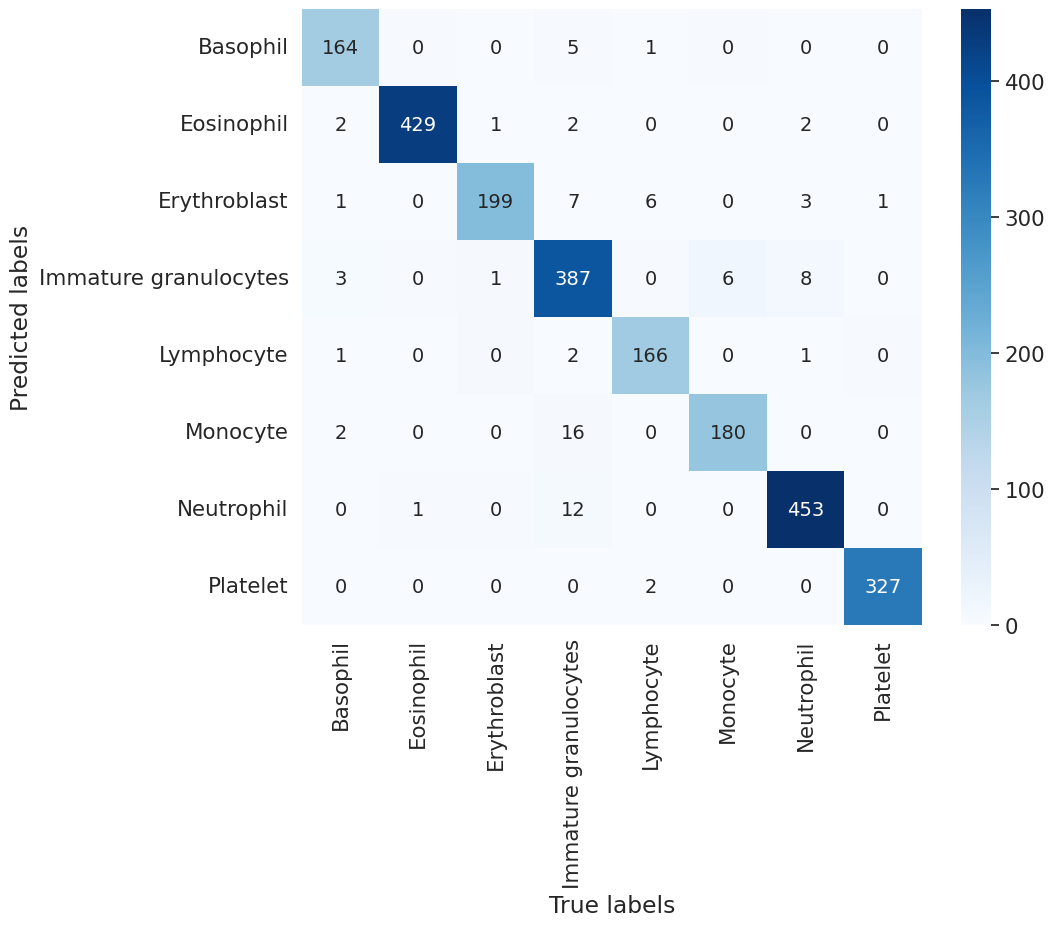

In [80]:
# Predict labels for the entire test set
predictions1 = ft_model1.predict(X_test, verbose=0)

# Convert predictions to class labels
pred_classes1 = np.argmax(predictions1, axis=-1)

# Extract ground truth classes
true_classes = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
accuracy1 = accuracy_score(true_classes, pred_classes1)
print(f'Accuracy 1 score over the test set: {round(accuracy1, 4)}')

# Calculate and display test set precision
precision1 = precision_score(true_classes, pred_classes1, average='weighted')
print(f'Precision 1 score over the test set: {round(precision1, 4)}')

# Calculate and display test set recall
recall1 = recall_score(true_classes, pred_classes1, average='weighted')
print(f'Recall score 1 over the test set: {round(recall1, 4)}')

# Calculate and display test set F1 score
f11 = f1_score(true_classes, pred_classes1, average='weighted')
print(f'F1 score 1 over the test set: {round(f11, 4)}')

# Compute the confusion matrix
cm1 = confusion_matrix(true_classes, pred_classes1)

# Combine numbers and percentages into a single string for annotation
annot1 = np.array([f"{num}" for num in cm1.flatten()]).reshape(cm1.shape)

# Define class labels
labels = {0: "Basophil", 1: "Eosinophil", 2: "Erythroblast", 3: "Immature granulocytes",
          4: "Lymphocyte", 5: "Monocyte", 6: "Neutrophil", 7: "Platelet"}

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm1.T, annot=annot1, fmt='', xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

Accuracy 2 score over the test set: 0.9038
Precision 2 score over the test set: 0.9106
Recall score 2 over the test set: 0.9038
F1 score 2 over the test set: 0.904


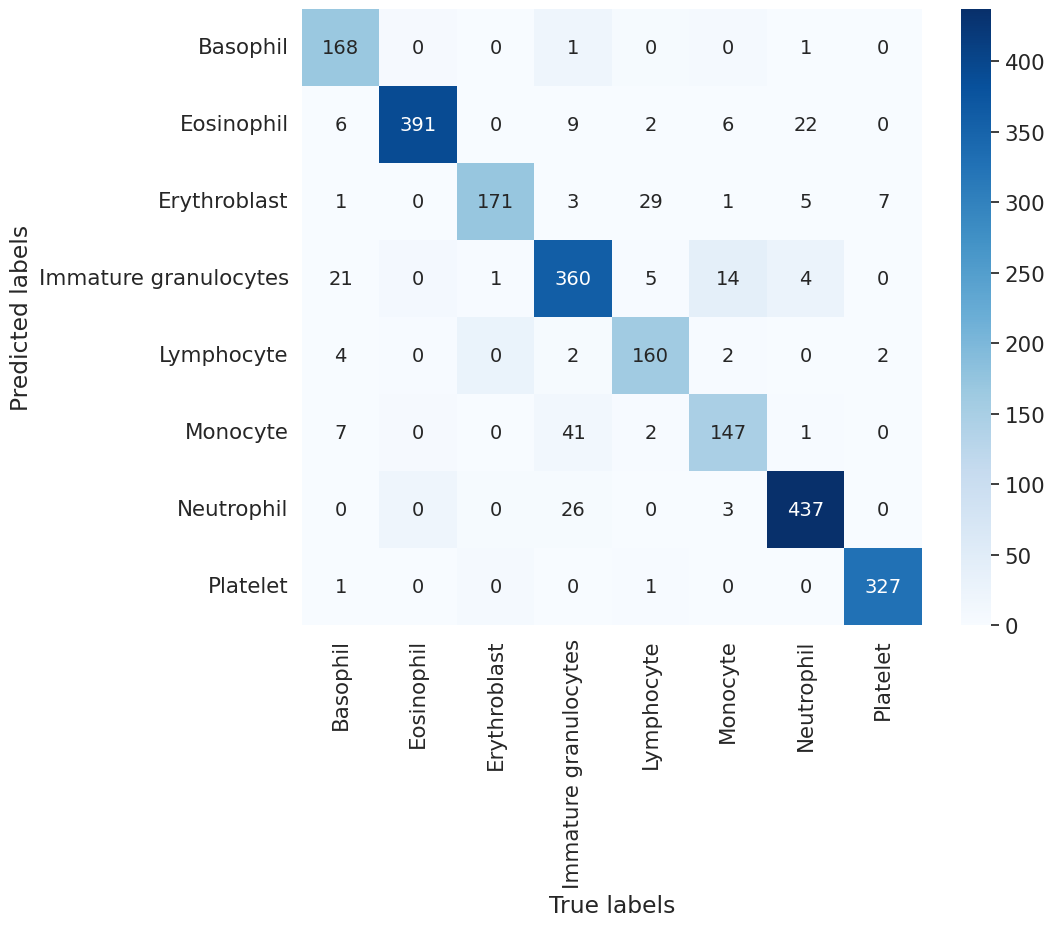

In [81]:
# Predict labels for the entire test set
predictions2 = ft_model2.predict(X_test, verbose=0)

# Convert predictions to class labels
pred_classes2 = np.argmax(predictions2, axis=-1)

# Extract ground truth classes
true_classes = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
accuracy2 = accuracy_score(true_classes, pred_classes2)
print(f'Accuracy 2 score over the test set: {round(accuracy2, 4)}')

# Calculate and display test set precision
precision2 = precision_score(true_classes, pred_classes2, average='weighted')
print(f'Precision 2 score over the test set: {round(precision2, 4)}')

# Calculate and display test set recall
recall2 = recall_score(true_classes, pred_classes2, average='weighted')
print(f'Recall score 2 over the test set: {round(recall2, 4)}')

# Calculate and display test set F1 score
f12 = f1_score(true_classes, pred_classes2, average='weighted')
print(f'F1 score 2 over the test set: {round(f12, 4)}')

# Compute the confusion matrix
cm2 = confusion_matrix(true_classes, pred_classes2)

# Combine numbers and percentages into a single string for annotation
annot2 = np.array([f"{num}" for num in cm2.flatten()]).reshape(cm2.shape)

# Define class labels
labels = {0: "Basophil", 1: "Eosinophil", 2: "Erythroblast", 3: "Immature granulocytes",
          4: "Lymphocyte", 5: "Monocyte", 6: "Neutrophil", 7: "Platelet"}

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm2.T, annot=annot2, fmt='', xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

Accuracy 3 score over the test set: 0.9051
Precision 3 score over the test set: 0.9093
Recall score 3 over the test set: 0.9051
F1 score 3 over the test set: 0.9053


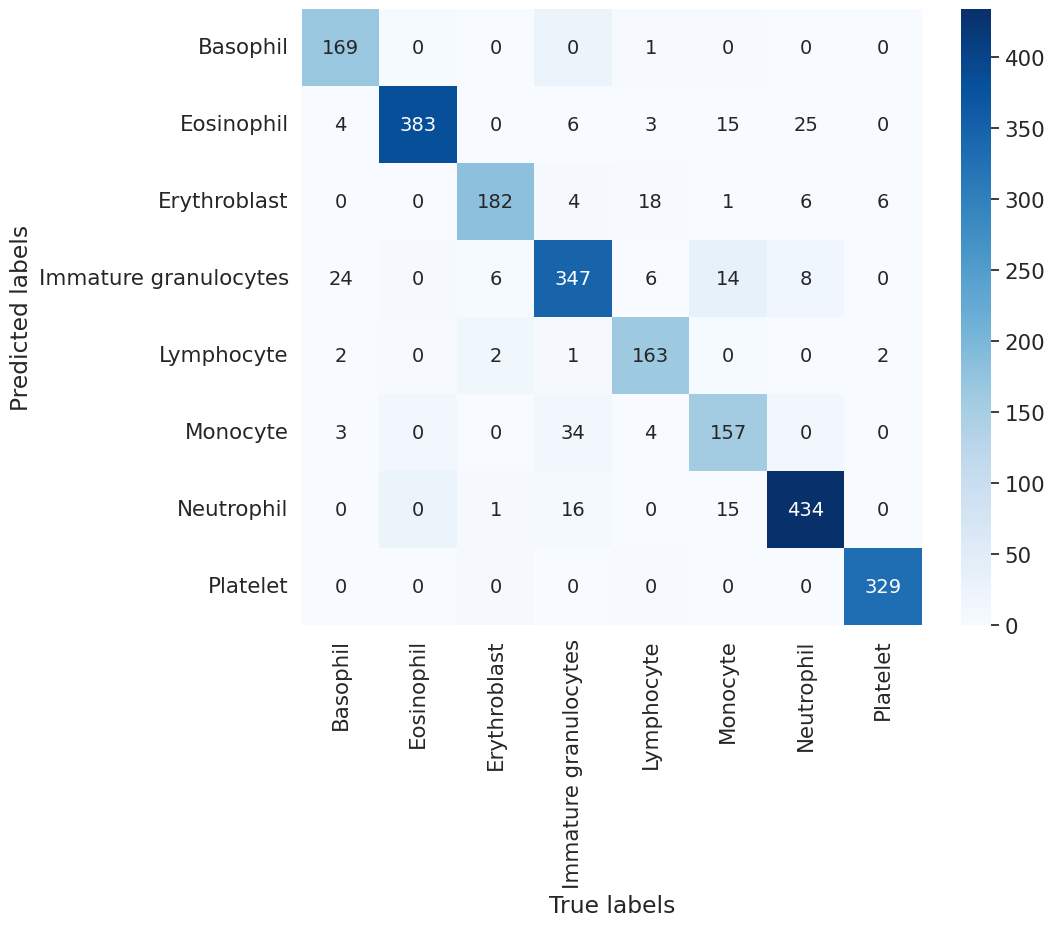

In [82]:
# Predict labels for the entire test set
predictions3 = ft_model3.predict(X_test, verbose=0)

# Convert predictions to class labels
pred_classes3 = np.argmax(predictions3, axis=-1)

# Extract ground truth classes
true_classes = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
accuracy3 = accuracy_score(true_classes, pred_classes3)
print(f'Accuracy 3 score over the test set: {round(accuracy3, 4)}')

# Calculate and display test set precision
precision3 = precision_score(true_classes, pred_classes3, average='weighted')
print(f'Precision 3 score over the test set: {round(precision3, 4)}')

# Calculate and display test set recall
recall3 = recall_score(true_classes, pred_classes3, average='weighted')
print(f'Recall score 3 over the test set: {round(recall3, 4)}')

# Calculate and display test set F1 score
f13 = f1_score(true_classes, pred_classes3, average='weighted')
print(f'F1 score 3 over the test set: {round(f13, 4)}')

# Compute the confusion matrix
cm3 = confusion_matrix(true_classes, pred_classes3)

# Combine numbers and percentages into a single string for annotation
annot3 = np.array([f"{num}" for num in cm3.flatten()]).reshape(cm3.shape)

# Define class labels
labels = {0: "Basophil", 1: "Eosinophil", 2: "Erythroblast", 3: "Immature granulocytes",
          4: "Lymphocyte", 5: "Monocyte", 6: "Neutrophil", 7: "Platelet"}

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm3.T, annot=annot3, fmt='', xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

#### 2. Test set with augmentation

Accuracy 1 score over the test set augmented: 0.7101
Precision 1 score over the test set augmented: 0.7155
Recall score 1 over the test set augmented: 0.7101
F1 score 1 over the test set augmented: 0.71


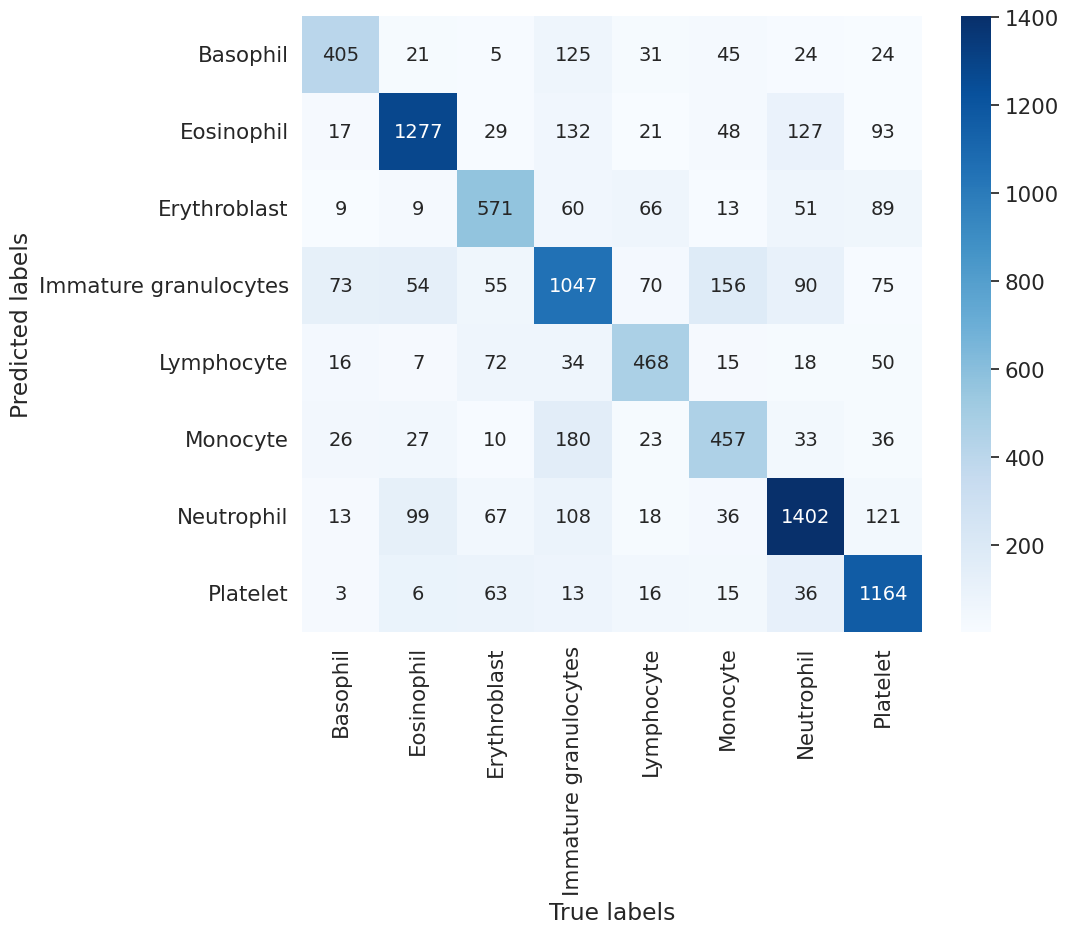

In [83]:
# Predict labels for the entire test set
predictions1_aug = ft_model1.predict(X_test_augmented, verbose=0)

# Convert predictions to class labels
pred_classes1_aug = np.argmax(predictions1_aug, axis=-1)

# Extract ground truth classes
true_classes_aug = np.argmax(y_test_augmented, axis=-1)

# Calculate and display test set accuracy
accuracy1_aug = accuracy_score(true_classes_aug, pred_classes1_aug)
print(f'Accuracy 1 score over the test set augmented: {round(accuracy1_aug, 4)}')

# Calculate and display test set precision
precision1_aug = precision_score(true_classes_aug, pred_classes1_aug, average='weighted')
print(f'Precision 1 score over the test set augmented: {round(precision1_aug, 4)}')

# Calculate and display test set recall
recall1_aug = recall_score(true_classes_aug, pred_classes1_aug, average='weighted')
print(f'Recall score 1 over the test set augmented: {round(recall1_aug, 4)}')

# Calculate and display test set F1 score
f11_aug = f1_score(true_classes_aug, pred_classes1_aug, average='weighted')
print(f'F1 score 1 over the test set augmented: {round(f11_aug, 4)}')

# Compute the confusion matrix
cm1_aug = confusion_matrix(true_classes_aug, pred_classes1_aug)

# Combine numbers and percentages into a single string for annotation
annot1_aug = np.array([f"{num}" for num in cm1_aug.flatten()]).reshape(cm1_aug.shape)

# Define class labels
labels = {0: "Basophil", 1: "Eosinophil", 2: "Erythroblast", 3: "Immature granulocytes",
          4: "Lymphocyte", 5: "Monocyte", 6: "Neutrophil", 7: "Platelet"}

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm1_aug.T, annot=annot1_aug, fmt='', xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

Accuracy 2 score over the test set augmented: 0.6313
Precision 2 score over the test set augmented: 0.6406
Recall score 2 over the test set augmented: 0.6313
F1 score 2 over the test set augmented: 0.6298


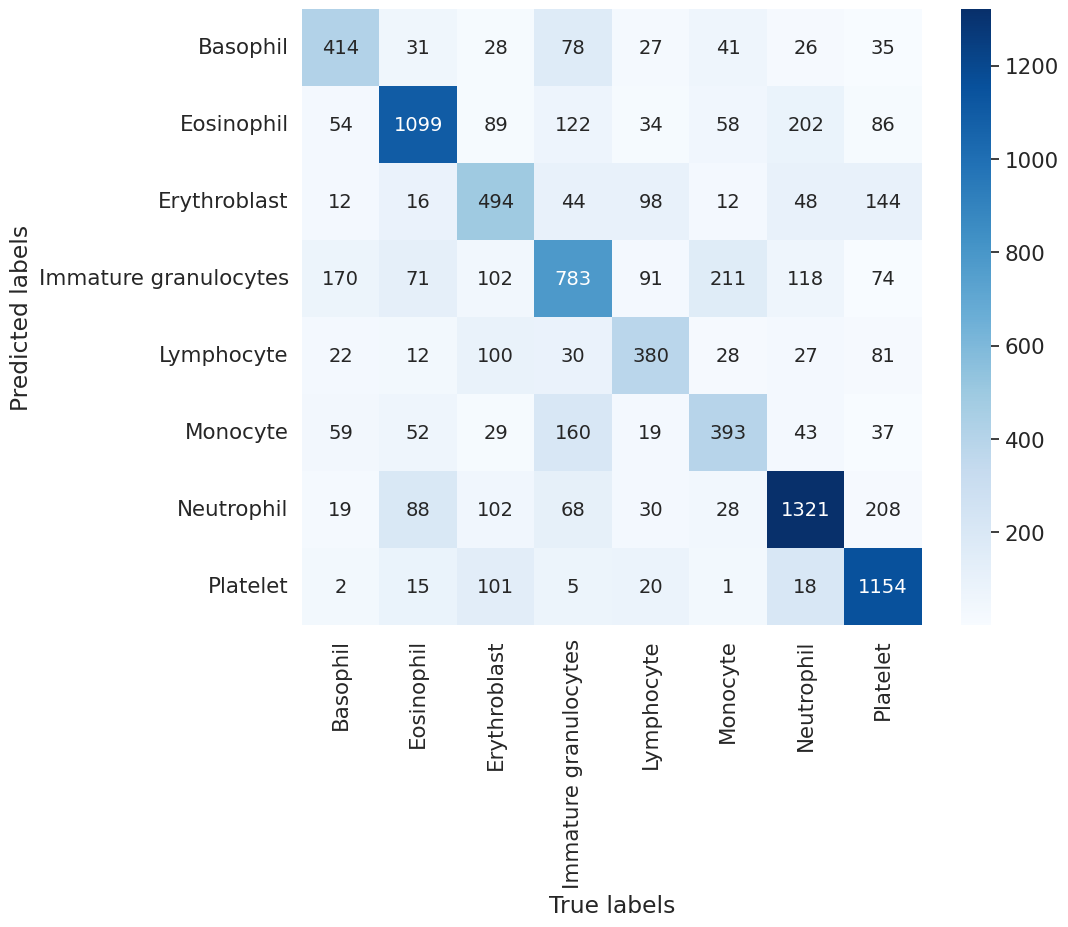

In [84]:
# Predict labels for the entire test set
predictions2_aug = ft_model2.predict(X_test_augmented, verbose=0)

# Convert predictions to class labels
pred_classes2_aug = np.argmax(predictions2_aug, axis=-1)

# Extract ground truth classes
true_classes_aug = np.argmax(y_test_augmented, axis=-1)

# Calculate and display test set accuracy
accuracy2_aug = accuracy_score(true_classes_aug, pred_classes2_aug)
print(f'Accuracy 2 score over the test set augmented: {round(accuracy2_aug, 4)}')

# Calculate and display test set precision
precision2_aug = precision_score(true_classes_aug, pred_classes2_aug, average='weighted')
print(f'Precision 2 score over the test set augmented: {round(precision2_aug, 4)}')

# Calculate and display test set recall
recall2_aug = recall_score(true_classes_aug, pred_classes2_aug, average='weighted')
print(f'Recall score 2 over the test set augmented: {round(recall2_aug, 4)}')

# Calculate and display test set F1 score
f12_aug = f1_score(true_classes_aug, pred_classes2_aug, average='weighted')
print(f'F1 score 2 over the test set augmented: {round(f12_aug, 4)}')

# Compute the confusion matrix
cm2_aug = confusion_matrix(true_classes_aug, pred_classes2_aug)

# Combine numbers and percentages into a single string for annotation
annot2_aug = np.array([f"{num}" for num in cm2_aug.flatten()]).reshape(cm2_aug.shape)

# Define class labels
labels = {0: "Basophil", 1: "Eosinophil", 2: "Erythroblast", 3: "Immature granulocytes",
          4: "Lymphocyte", 5: "Monocyte", 6: "Neutrophil", 7: "Platelet"}

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm2_aug.T, annot=annot2_aug, fmt='', xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

Accuracy 3 score over the test set augmented: 0.6239
Precision 3 score over the test set augmented: 0.6538
Recall score 3 over the test set augmented: 0.6239
F1 score 3 over the test set augmented: 0.6254


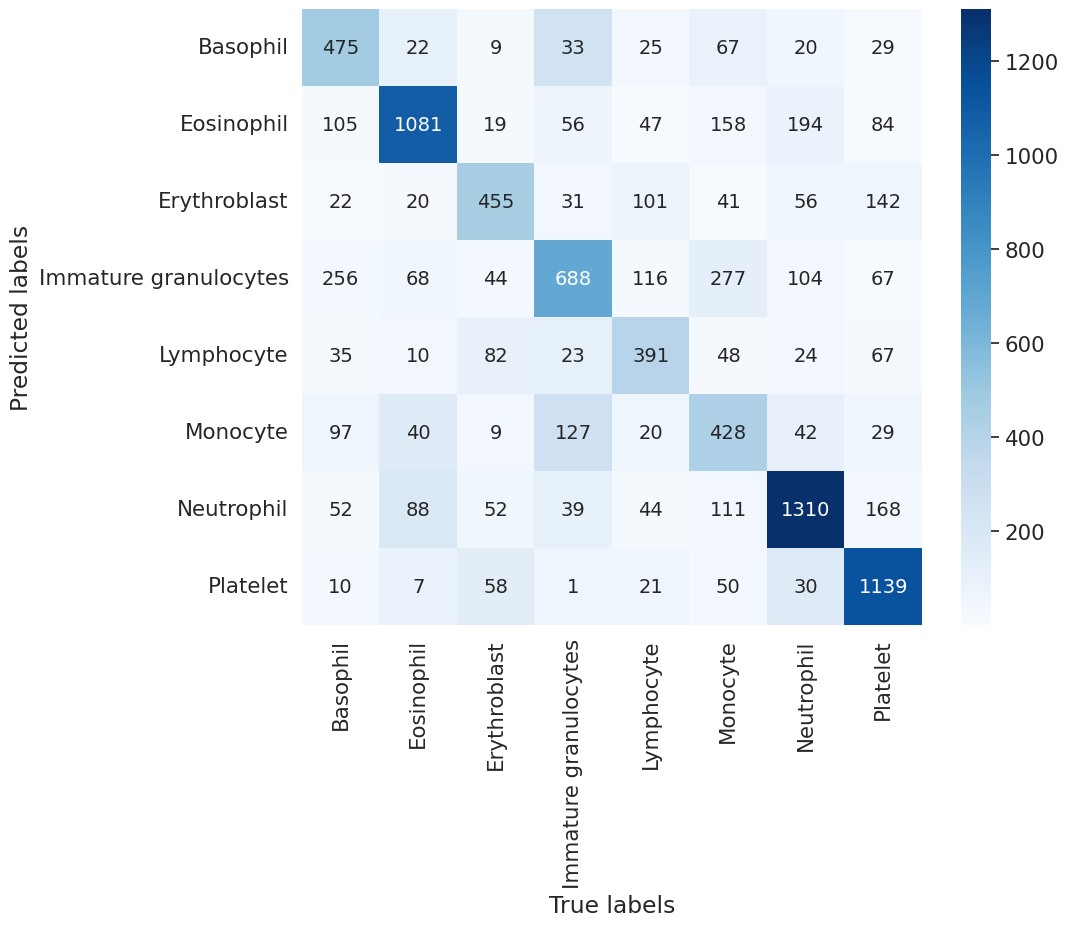

In [85]:
# Predict labels for the entire test set
predictions3_aug = ft_model3.predict(X_test_augmented, verbose=0)

# Convert predictions to class labels
pred_classes3_aug = np.argmax(predictions3_aug, axis=-1)

# Extract ground truth classes
true_classes_aug = np.argmax(y_test_augmented, axis=-1)

# Calculate and display test set accuracy
accuracy3_aug = accuracy_score(true_classes_aug, pred_classes3_aug)
print(f'Accuracy 3 score over the test set augmented: {round(accuracy3_aug, 4)}')

# Calculate and display test set precision
precision3_aug = precision_score(true_classes_aug, pred_classes3_aug, average='weighted')
print(f'Precision 3 score over the test set augmented: {round(precision3_aug, 4)}')

# Calculate and display test set recall
recall3_aug = recall_score(true_classes_aug, pred_classes3_aug, average='weighted')
print(f'Recall score 3 over the test set augmented: {round(recall3_aug, 4)}')

# Calculate and display test set F1 score
f13_aug = f1_score(true_classes_aug, pred_classes3_aug, average='weighted')
print(f'F1 score 3 over the test set augmented: {round(f13_aug, 4)}')

# Compute the confusion matrix
cm3_aug = confusion_matrix(true_classes_aug, pred_classes3_aug)

# Combine numbers and percentages into a single string for annotation
annot3_aug = np.array([f"{num}" for num in cm3_aug.flatten()]).reshape(cm3_aug.shape)

# Define class labels
labels = {0: "Basophil", 1: "Eosinophil", 2: "Erythroblast", 3: "Immature granulocytes",
          4: "Lymphocyte", 5: "Monocyte", 6: "Neutrophil", 7: "Platelet"}

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm3_aug.T, annot=annot3_aug, fmt='', xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## 📊 Prepare Your Submission

To prepare your submission, create a `.zip` file that includes all the necessary code to run your model. It **must** include a `model.py` file with the following class:

```python

# file: model.py

import tensorflow as tf
import numpy as np

class Model:
    def __init__(self):
        """Initialize the internal state of the model."""

        # Load the pre-trained model weights
        self.model = tf.keras.models.load_model('weights.keras')  # Path to your saved weights

    def predict(self, X):
        """
        Return a numpy array with the labels corresponding to the input X.
        X: numpy array of input images.
        """
        predictions = self.model.predict(X)
        # Return the class labels as a numpy array
        return np.argmax(predictions, axis=-1)

The next cell shows an example implementation of the `model.py` file, which includes loading model weights from the `weights.keras` file and conducting predictions on provided input data. The `.zip` file is created and downloaded in the last notebook cell.

❗ Feel free to modify the method implementations to better fit your specific requirements, but please ensure that the class name and method interfaces remain unchanged.

In [1]:
%%writefile model.py

import numpy as np
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.
        """
        # Load the specific model file
        self.neural_network = tfk.models.load_model('VGGFTfull1_83.77.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must not be one-hot
        encoded.

        This function returns class labels as integers.
        """
        # Get predictions and convert to label format
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Writing model.py


In [2]:
from datetime import datetime

filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py VGGFTfull1_83.77.keras

  adding: model.py (deflated 52%)
  adding: VGGFTfull1_83.77.keras (deflated 6%)
